# Layer-specific fMRI processing pipeline: structural processing

Employing the "wisdom-of-the-crowd" approach described in [de Hollander et al., 2021]

As in [de Hollander et al., 2021], the correspondence between locations on the inner and outer surface of the cortical sheet is central to some of our research questions (e.g., comparing pRF properties across layers). Thus, we mainly focus on the surface inflation-approach of Freesurfer (Polimeni et al., 2018), rather than the level set-based approach of CBS tools/Nighres (Bazin et al., 2014; Huntenburg et al., 2018). The goals of the structural processing workflow are:
1) Freesurfer-derived cortical representations, consisting of white matter and pial meshes (Dale et al., 1999)
2) CBS tools-derived level set representations of white matter and pial surface reconstructions (Bazin et al., 2014; Waehnert et al., 2014)

While manual intervention is unavoidable, the goal was to minimize manual intervention, combining a variety of segmentation algorithms before applying manual corrections and using these to re-run the automated pipeline. 

The steps implemented in the pipeline are as follows:
- "denoise" the UNI image using a tool provided by Marc Pabst , based on [O'Brien et al., 2014]
- correct mean second inversion (INV2), T1 map, and denoised UNI for bias fields using N4BiasFieldCorrection (Tustison et al., 2010), distributed with ANTs
- the bias-corrected INV2 used as input to FSL's brain extraction tool (BET; Jenkinson et al., 2005; 2012)
- the skull-stripped INV2 used as input to AFNI's AutoMask to estimate background noise level and remove voxels that only contain noise
- the T1UNI, INV2 and T1 map used as input to MP2RAGE skull strip and MP2RAGE dura estimation modules of CBS tools (Bazin et al., 2014), as wrapped by Nighres (Huntenburg et al., 2018) to make masks of the dura and the skull
- the dura probabilistic map was thresholded at 0.8 and then dilated by 2 voxels 
- the above mask, together with the noise voxel mask from AFNI was used to exclude voxels from the T1UNI and INV2 images

The graph, with its different modules, is visualized below.
- red module: Nighres
- green module: FS directly on denoised & bias corrected UNI
- blue module: FS with optimized brain mask

Issues to resolve:
- take Dicom images as input, use BIDs format at pipeline start
- sagittal sinus missegmentation

In [1]:
import os
os.chdir('/home/mayaaj90/projects/project-00-7t-pipeline-dev/code/notebooks/')

In [2]:
os.listdir()

['project-00-7t-pipeline-dev-advanced-skullstrip.ipynb',
 'crash-20230321-094155-mayaaj90-datasourceManualEdits-aaebfe6f-bdfc-4c11-821c-1c3ccbae4c38.pklz',
 'crash-20230413-101721-mayaaj90-autorecon1.a2-8a32019f-597c-451f-b7f1-7e4c3cde4842.pklz',
 '.ipynb_checkpoints',
 'crash-20230413-031833-mayaaj90-autorecon1.a2-4c7a3e28-ef68-49ab-835d-73ea24cf207f.pklz',
 'crash-20230411-164708-mayaaj90-autorecon1.a2-374d13ab-b7cb-4dd3-b8c2-e5b4d088ca87.pklz',
 'crash-20230413-013137-mayaaj90-autorecon1.a0-74ca6e57-0dbc-40ff-9f32-9a8650b758ba.pklz',
 'crash-20221213-131423-mayaaj90-autorecon_regenerate_surfaces-d38f0cea-971d-4466-9982-08adbbd47291.pklz',
 'crash-20230411-223818-mayaaj90-getBrainFinalsurfsMgz_FSExternal.a0-3b916882-63d7-41fe-a05a-439728ba64d9.pklz',
 'project-00-7t-pipeline-dev-functional-pRF.ipynb',
 'crash-20230411-171840-mayaaj90-getBrainFinalsurfsMgz_FSNative.a2-2460cd4b-07c4-49ee-8cf4-6bed5254fafb.pklz',
 'crash-20230502-164836-mayaaj90-autorecon1.a0-b386f1fa-6b84-4692-92de-b83

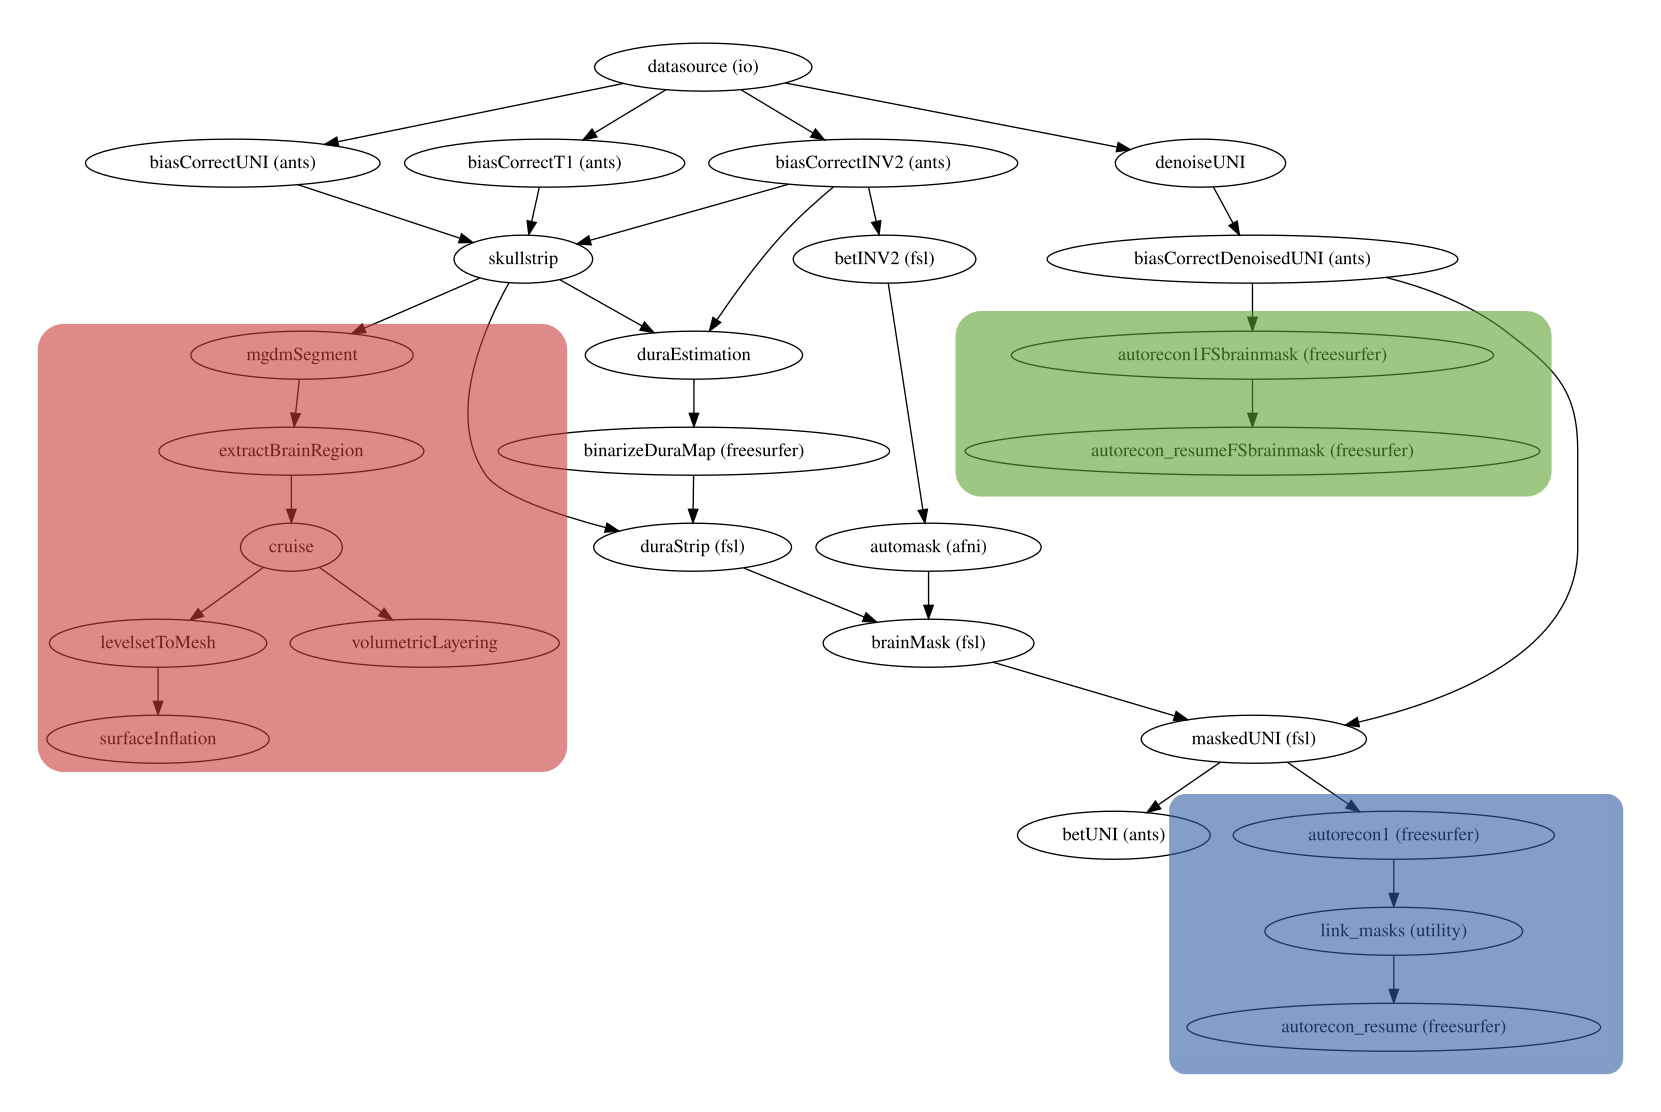

In [3]:
from IPython.display import Image
Image(filename='workflowgraph_advanced-skullstrip.png')

### Set preferences
Whether or not to write the workflow viz graph, run pipeline, run specific branches of workflow...

In [4]:
# whether or not to write workflow graph (svg)
write_graph  = True                

# whether or not to run the pipeline
run_pipeline = True                           

# red branch in workflow above
run_nighres_branch = True        

# green branch in workflow above (native FS brainmask)
run_FSnative_branch = False           

# blue branch in workflow above (external brainmask)
run_FSexternal_branch = True 

# whether manual edits exist (for coregistration)
manual_edits = True  
wm_edits     = False
gm_edits     = True

# set wm and gm edits to false if manual edits have not been done
if not manual_edits:
    wm_edits = False
    gm_edits = False

# used when manual edits have been made to mri/brainmask.mgz in the FS folder corresponding to the blue branch
regenerate_surfaces = True                   
if not manual_edits:
    regenerate_surfaces = False

import os
n_procs = int(os.getenv('OMP_NUM_THREADS'))   # number of cores to use
#n_procs = 1


### Set paths
All computer-dependent paths

In [5]:
from os.path import join as opj

doc_dir = '/home/mayaaj90/'
data_dir = '/scratch/mayaaj90/project-00-7t-pipeline-dev/'

# general software directory
software_dir = opj(doc_dir,'programs')

# directory containing mp2rage software
denoise_dir = opj(software_dir,'mp2rage-denoise-master')

# SPM dir
spm_dir = opj(software_dir,'spm12')

# raw data directory
raw_data_dir = opj(data_dir,'raw')

# workflow derivatives directory
der_dir = opj(data_dir,'derivatives')

# output directory for datasink
out_dir = opj(data_dir,'output')

# pRF directory
pRF_dir = opj(data_dir,'pRF')

# OASIS template
# downloaded from https://fcp-indi.github.io/docs/latest/user/anat
oasis_dir = opj(software_dir,'OASIS','MICCAI2012-Multi-Atlas-Challenge-Data')
bet_ants_template = opj(oasis_dir,'T_template0.nii.gz')
bet_ants_prob_mask = opj(oasis_dir,'T_template0_BrainCerebellumProbabilityMask.nii.gz')
bet_ants_registration_mask = opj(oasis_dir,'T_template0_BrainCerebellumRegistrationMask.nii.gz')
bet_ants_extraction_mask = opj(oasis_dir,'T_template0_BrainCerebellumExtractionMask.nii.gz')

# Sinus atlas
# see: Kurzawski et al., The influence of non-neural factors on BOLD signal magnitude
# preprint: https://www.biorxiv.org/content/10.1101/2021.12.26.474185v1
# downloaded from https://osf.io/2nc4x/
sinus_atlas = opj(software_dir,'sinus_atlas_MNI1mm.nii.gz')

### Imports
Import required libraries, set paths

In [6]:
from nilearn import plotting
%matplotlib inline

from nipype.interfaces.io import DataGrabber, DataSink

from nipype import Node, JoinNode, Workflow

#import nipype_settings
import nipype.interfaces.matlab as Matlab
from nipype.interfaces.base import TraitedSpec, \
    BaseInterface, BaseInterfaceInputSpec, File, \
    Directory

from string import Template

import sys
sys.path.append(denoise_dir)
from mp2rage_denoise import mp2rage_robust_combination

from nipype.interfaces.utility import Function, IdentityInterface, Select, Rename
from nipype.interfaces.base import BaseInterface, BaseInterfaceInputSpec, CommandLine, Directory, File, TraitedSpec, traits

import nibabel as nib

from os.path import abspath

import pygraphviz 

from nipype import config
config.enable_debug_mode()

from nipype.interfaces.freesurfer import ReconAll, MRIConvert


# set SPM path
os.environ['SPM_PATH']=spm_dir

from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths(spm_dir)

from nipype.interfaces import spm
#spm.SPMCommand.set_mlab_paths(paths=os.environ['SPM_PATH'])
#spm.SPMCommand().version

from nipype.utils.filemanip import copyfiles

# ants installation: http://miykael.github.io/nipype-beginner-s-guide/installation.html#ants
from nipype.interfaces.ants import N4BiasFieldCorrection
from nipype.interfaces.ants.segmentation import BrainExtraction

from nipype.interfaces.fsl import BET

from nipype.interfaces.fsl.maths import ApplyMask

from nipype.interfaces.freesurfer.model import Binarize

from nipype.interfaces.freesurfer.registration import MRICoreg
from nipype.interfaces.freesurfer.preprocess import BBRegister

from nipype.interfaces.fsl.maths import BinaryMaths
#from nipype.interfaces.niftyseg.maths import BinaryMaths
#from nipype.interfaces.niftyseg import BinaryMathsInteger
#!echo $SPM_PATH

from nipype.interfaces import utility as niu

import nighres

from nipype.interfaces.afni import Automask

from nipype.interfaces.fsl import Merge as fslMerge
from nipype.interfaces.utility.base import Merge as utilMerge
from nipype.interfaces.fsl import MultiImageMaths

#from nipype.interfaces.mipav.developer import JistIntensityMp2rageMasking, MedicAlgorithmSPECTRE2010

/home/mayaaj90/anaconda3/envs/py36/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


230502-18:20:44,11 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.7.1


### Specify important variables

In [7]:
wf_name = 'wf_advanced_skullstrip'

# subject_list = ['sub-01','sub-02','sub-03']            # subject identifiers
subject_list = ['sub-03']
#subject_list = ['sub-04']                             # sub-04 doesn't have a T1map -> process separately

UNI_id       = 'UNI.nii'                               # name of T1 UNI image
INV1_id      = 'INV1.nii'                              # name of INV1 image
INV2_id      = 'INV2.nii'                              # name of INV2 image
T1_id        = 'T1.nii'                                # name of T1map image

exists_T1    = True                                    # whether or not T1map exists (this depends on sub-id
                                                       # and is dealt with below)
    
manual_wm_id = 'wm.mgz'                                # name of white matter manual edits file in
                                                       # manualcorr/sub-0*/brainmask_FSexternal directory

manual_brainmask_id = 'brain.finalsurfs.mgz'           # name of manual edits file in 
                                                       # manualcorr/sub-0*/brainmask_FSexternal directory
    

Deal with missing data (T1map for sub-04)

In [8]:
import functools

if functools.reduce(lambda x, y : x and y, map(lambda p, q: p == q,subject_list,['sub-04']), True): 
    print('sub-04: T1map is missing. Proceed accordingly.')
    exists_T1 = False
    run_nighres_branch = False
    run_FSnative_branch = False
    wf_name = 'wf_advanced_skullstrip_sub-04'
else:
    print('No worries, all data should be present')    

No worries, all data should be present
Number of threads used for FS: 0.5


### Create workflow
About connecting nodes: https://nipype.readthedocs.io/en/0.11.0/users/joinnode_and_itersource.html

In [9]:
wf = Workflow(name=wf_name, base_dir=der_dir)

### Subjects

In [10]:
subjects = Node(interface=IdentityInterface(fields=['subject_id']),name='subjects')

subjects.iterables = ('subject_id', subject_list)

### Grab data

DataGrabber is an interface for collecting files from hard drive. It is very flexible and supports almost any file organization of your data you can imagine.
<br>More info: https://nipype.readthedocs.io/en/0.11.0/users/grabbing_and_sinking.html

#### UNI image files

In [11]:
if exists_T1:
    datasource = Node(DataGrabber(infields=['subject_id'], outfields=['UNI', 'INV1', 'INV2','T1', 'subject_id']),
                     name='datasource')
    datasource.inputs.base_directory = raw_data_dir
    datasource.inputs.sort_filelist = False
    datasource.inputs.template = '*'
    datasource.inputs.field_template = dict(UNI='%s/anat/'+UNI_id,
                                            INV1='%s/anat/'+INV1_id,
                                            INV2='%s/anat/'+INV2_id,
                                            T1='%s/anat/'+T1_id)
    datasource.inputs.template_args = dict(UNI=[['subject_id']],
                                           INV1=[['subject_id']],
                                           INV2=[['subject_id']],
                                           T1=[['subject_id']])
else:
    datasource = Node(DataGrabber(infields=['subject_id'], outfields=['UNI', 'INV1', 'INV2', 'subject_id']),
                     name='datasource')
    datasource.inputs.base_directory = raw_data_dir
    datasource.inputs.sort_filelist = False
    datasource.inputs.template = '*'
    datasource.inputs.field_template = dict(UNI='%s/anat/'+UNI_id,
                                            INV1='%s/anat/'+INV1_id,
                                            INV2='%s/anat/'+INV2_id)
    datasource.inputs.template_args = dict(UNI=[['subject_id']],
                                           INV1=[['subject_id']],
                                           INV2=[['subject_id']])
#datasource.iterables = ('subject_id', subject_list)

In [12]:
wf.connect([(subjects, datasource,
                   [('subject_id', 'subject_id')])])

230502-18:20:52,592 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.subjects, wf_advanced_skullstrip.datasource): No edge data
230502-18:20:52,594 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.subjects, wf_advanced_skullstrip.datasource): new edge data: {'connect': [('subject_id', 'subject_id')]}


#### Manual edits
(if they exist)

In [13]:
datasourceManualEdits = Node(DataGrabber(infields=['subject_id'], outfields=['manual_wm',
                                                                             'manual_brainmask',
                                                                             'subject_id']),
                 name='datasourceManualEdits')
datasourceManualEdits.inputs.base_directory = data_dir
datasourceManualEdits.inputs.sort_filelist = False
datasourceManualEdits.inputs.template = '*'
datasourceManualEdits.inputs.field_template = dict(manual_wm='manualcorr/freesurfer_externalbrainmask/_subject_id_%s/'+manual_wm_id,
                                                   manual_brainmask='manualcorr/freesurfer_externalbrainmask/_subject_id_%s/'+manual_brainmask_id
                                       )
datasourceManualEdits.inputs.template_args = dict(manual_wm=[['subject_id']],
                                                  manual_brainmask=[['subject_id']]
                                       )

In [14]:
datasourceManualEditsGM = Node(DataGrabber(infields=['subject_id'], outfields=['manual_brainmask',
                                                                             'subject_id']),
                 name='datasourceManualEditsGM')
datasourceManualEditsGM.inputs.base_directory = data_dir
datasourceManualEditsGM.inputs.sort_filelist = False
datasourceManualEditsGM.inputs.template = '*'
datasourceManualEditsGM.inputs.field_template = dict(manual_brainmask='manualcorr/freesurfer_externalbrainmask/_subject_id_%s/'+manual_brainmask_id
                                       )
datasourceManualEditsGM.inputs.template_args = dict(manual_brainmask=[['subject_id']]
                                       )

In [15]:
if manual_edits and wm_edits and gm_edits: 
    wf.connect([(subjects, datasourceManualEdits, [('subject_id', 'subject_id')])])
elif manual_edits and not wm_edits and gm_edits:
    wf.connect([(subjects, datasourceManualEditsGM, [('subject_id', 'subject_id')])])

230502-18:20:52,696 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.subjects, wf_advanced_skullstrip.datasourceManualEditsGM): No edge data
230502-18:20:52,698 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.subjects, wf_advanced_skullstrip.datasourceManualEditsGM): new edge data: {'connect': [('subject_id', 'subject_id')]}


### Remove MP2Rage Background Noise

Using an implementation by Marc Pabst - a Python version of the RobustCombination function described by O'Brien et al. and originally implemented by Jose Marques. Downloaded 06/2021 from: <a> https://github.com/marcpabst/mp2rage-denoise/blob/master/mp2rage_denoise.py</a>

<hr>
   

<i> The MP2Rage (magnetization prepared 2 rapid gradient echoes) sequence is often used at 7 Tesla MRI scanners to get T1-weighted anatomical measurements with very good grey-white matter contrast. It typically results in a series of 3D volumes containig different weightings, including the "UNI", "INV1" and "INV2" files. The UNI volume is supposed to be used for further processing but its background voxels exhibit high intensity values which makes subsequent processing and visualization difficult. Here we use a tool provided by Marc Pabst to "denoise" the UNI volume, based on the publication by O'Brien et al. (2014). The resulting denoised UNI volume appears with a rather clean background as one might know from conventional T1w sequences such as the MPRage. The O'Brien et al. (2014) denoising technique does not require availability of phase images but one needs to provide the "INV1" and "INV2" images containing the first and second inversion times.
    <br> Explanation adapted from: <a> http://www.brainvoyager.com/bv/doc/UsersGuide/Segmentation/RemovingMP2RageBackgroundNoise.html</a>

#### Define inputs

In [16]:
# output filename
filename_output = UNI_id

# multiplying factor (if it's too noisy, give it a bigger value)
multiplying_factor=7 #[5,6,7,8,9,10]

The above work, but we want to put the python func in a node of the workflow, so we need to create an interface...

#### Create Python function interface

In [17]:
class DenoiseMP2RageInputSpec(BaseInterfaceInputSpec):
    filename_uni = File(exists=True, mandatory=True, desc='the input UNI image')
    filename_inv1 = File(exists=True, mandatory=True, desc='the input INV1 image')
    filename_inv2 = File(exists=True, mandatory=True, desc='the input INV2 image')
    filename_output = File(mandatory=True, desc='the output denoised image') # Do not set exists=True !!
    multiplying_factor = traits.Int(7, desc='the multiplying factor')
        
class DenoiseMP2RageOutputSpec(TraitedSpec):
    filename_output = File(desc='the output denoised image')

class DenoiseMP2Rage(BaseInterface):
    input_spec = DenoiseMP2RageInputSpec
    output_spec = DenoiseMP2RageOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        mp2rage_robust_combination(
            self.inputs.filename_uni,
            self.inputs.filename_inv1,
            self.inputs.filename_inv2,
            self.inputs.filename_output,
            self.inputs.multiplying_factor
        )
        # And we are done
        return runtime

    def _list_outputs(self):
        return {'filename_output': self.inputs.filename_output}

In [18]:
denoiseUNI = Node(DenoiseMP2Rage(filename_output=filename_output,
                             multiplying_factor=multiplying_factor), name="denoiseUNI")
#denoise.iterables = ('multiplying_factor', multiplying_factor)

In [19]:
wf.connect([(datasource, denoiseUNI,
                   [('UNI', 'filename_uni'),
                    ('INV1','filename_inv1'),
                    ('INV2','filename_inv2')]
                  )])

230502-18:20:52,860 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.denoiseUNI): No edge data
230502-18:20:52,862 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.denoiseUNI): new edge data: {'connect': [('UNI', 'filename_uni'), ('INV1', 'filename_inv1'), ('INV2', 'filename_inv2')]}


### Bias field correction

ANTs bias field correction (UNI, INV2 & T1)
<br> <br>
See: https://manpages.debian.org/testing/ants/N4BiasFieldCorrection.1.en.html
    <br> <br>
    Used in fMRIPrep workflow (Esteban et al., fMRIPrep: a robust preprocessing pipeline for functional MRI, Nature Methods, 16(1): 111-116, 2019).
    
Also used, e.g., in Gilles de Hollander, Wietske van der Zwaag, Chencan Qian, Peng Zhang, Tomas Knapen,
Ultra-high field fMRI reveals origins of feedforward and feedback activity within laminae of human ocular dominance columns,
NeuroImage,
Volume 228,
2021 https://www.sciencedirect.com/science/article/pii/S105381192031168X

#N4BiasFieldCorrection.help()

#### Define inputs

In [20]:
biasCorrectDenoisedUNI = Node(N4BiasFieldCorrection(dimension=3), name="biasCorrectDenoisedUNI")

In [21]:
# connect to previous node for denoised UNI
wf.connect([(denoiseUNI,biasCorrectDenoisedUNI,[('filename_output','input_image')])])

230502-18:20:54,796 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.denoiseUNI, wf_advanced_skullstrip.biasCorrectDenoisedUNI): No edge data
230502-18:20:54,802 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.denoiseUNI, wf_advanced_skullstrip.biasCorrectDenoisedUNI): new edge data: {'connect': [('filename_output', 'input_image')]}


In [22]:
biasCorrectUNI = Node(N4BiasFieldCorrection(dimension=3), name="biasCorrectUNI")

In [23]:
# connect to previous node for denoised UNI
wf.connect([(datasource,biasCorrectUNI,[('UNI','input_image')])])

230502-18:20:54,878 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.biasCorrectUNI): No edge data
230502-18:20:54,880 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.biasCorrectUNI): new edge data: {'connect': [('UNI', 'input_image')]}


In [24]:
biasCorrectINV2 = Node(N4BiasFieldCorrection(dimension=3), name="biasCorrectINV2")

In [25]:
# connect to input node for INV2
wf.connect([(datasource,biasCorrectINV2,[('INV2','input_image')])])

230502-18:20:54,953 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.biasCorrectINV2): No edge data
230502-18:20:54,955 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.biasCorrectINV2): new edge data: {'connect': [('INV2', 'input_image')]}


In [26]:
biasCorrectT1 = Node(N4BiasFieldCorrection(dimension=3), name="biasCorrectT1")

In [27]:
# connect to input node for T1
if exists_T1:
    wf.connect([(datasource,biasCorrectT1,[('T1','input_image')])])

230502-18:20:55,40 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.biasCorrectT1): No edge data
230502-18:20:55,42 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasource, wf_advanced_skullstrip.biasCorrectT1): new edge data: {'connect': [('T1', 'input_image')]}


### Skull stripping of INV2

In [28]:
# BET output name
out_file = 'brainmask.nii'

# fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates 
frac = 0.5 #[0.1,0.2,0.3,0.4,0.5]

In [29]:
# FSL BET - run on INV2 image
betINV2 = Node(BET(out_file = out_file, frac = frac,
              output_type='NIFTI'),name='betINV2')
#betINV2.iterables = ('frac', frac)

In [30]:
wf.connect([(biasCorrectINV2,betINV2,[('output_image','in_file')])])

230502-18:20:55,134 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectINV2, wf_advanced_skullstrip.betINV2): No edge data
230502-18:20:55,136 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectINV2, wf_advanced_skullstrip.betINV2): new edge data: {'connect': [('output_image', 'in_file')]}


### Estimate background noise level and remove noise
https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dAutomask.html

#### Define inputs

In [31]:
# Set the 'clip level fraction' - a number between 0.1 and 0.9.
# A small 'cc' means to make the initial threshold
# for clipping (a la 3dClipLevel) smaller, which
# will tend to make the mask larger.  [default=0.5]
clfrac = 0.5 #[0.1,0.2]

In [32]:
automask = Node(Automask(outputtype='NIFTI', clfrac=clfrac),name='automask')
#automask.iterables = ('clfrac', clfrac)

In [33]:
wf.connect([(betINV2,automask,[('out_file','in_file')])])

230502-18:20:55,236 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.betINV2, wf_advanced_skullstrip.automask): No edge data
230502-18:20:55,237 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.betINV2, wf_advanced_skullstrip.automask): new edge data: {'connect': [('out_file', 'in_file')]}


In [34]:
Automask.help()

Wraps the executable command ``3dAutomask``.

Create a brain-only mask of the image using AFNI 3dAutomask command

For complete details, see the `3dAutomask Documentation.
<https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dAutomask.html>`_

Examples
--------
>>> from nipype.interfaces import afni
>>> automask = afni.Automask()
>>> automask.inputs.in_file = 'functional.nii'
>>> automask.inputs.dilate = 1
>>> automask.inputs.outputtype = 'NIFTI'
>>> automask.cmdline  # doctest: +ELLIPSIS
'3dAutomask -apply_prefix functional_masked.nii -dilate 1 -prefix functional_mask.nii functional.nii'
>>> res = automask.run()  # doctest: +SKIP

Inputs::

        [Mandatory]
        in_file: (a pathlike object or string representing an existing file)
                input file to 3dAutomask
                argument: ``%s``, position: -1

        [Optional]
        out_file: (a pathlike object or string representing a file)
                output image file name
                argument: ``-prefix %

### MP2RAGE skull strip
Nighres: https://nighres.readthedocs.io/en/latest/brain/mp2rage_skullstripping.html

#### Define inputs

In [35]:
# save output files
save_data = True

# output filenames (defaults from nighres)
brain_mask = 'INV2_corrected_strip-mask.nii'
inv2_masked = 'INV2_corrected_strip-inv2.nii'
t1w_masked = 'UNI_corrected_strip-t1w.nii'
t1map_masked = 'T1_corrected_strip-t1map.nii'

In [36]:
class MP2RageSkullStripInputSpec(BaseInterfaceInputSpec):
    second_inversion = File(exists=True, mandatory=True, desc='Second inversion image derived from MP2RAGE sequence')
    t1_weighted = File(exists=True, mandatory=True, desc='T1-weighted image derived from MP2RAGE sequence (also referred to as “uniform” image) At least one of t1_weighted and t1_map is required')
    t1_map = File(exists=True, mandatory=True, desc='Quantitative T1 map image derived from MP2RAGE sequence At least one of t1_weighted and t1_map is required')
    save_data = traits.Bool(True, desc='Save output data to file')
    
    brain_mask = File(mandatory=True, desc='The output binary brain mask') # Do not set exists=True !!
    inv2_masked = File(mandatory=True, desc='The output masked second inversion image') # Do not set exists=True !!
    t1w_masked = File(mandatory=True, desc='The output masked T1-weighted image') # Do not set exists=True !!
    t1map_masked = File(mandatory=True, desc='The output masked T1 map') # Do not set exists=True !!
    
        
class MP2RageSkullStripOutputSpec(TraitedSpec):
    brain_mask = File(desc='Binary brain mask')
    inv2_masked = File(desc='Masked second inversion image') 
    t1w_masked = File(desc='Masked T1-weighted image') 
    t1map_masked = File(desc='Masked T1 map') 

class MP2RageSkullStrip(BaseInterface):
    input_spec = MP2RageSkullStripInputSpec
    output_spec = MP2RageSkullStripOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        import nighres
        output_dir=os.getcwd()
        nighres.brain.mp2rage_skullstripping(
                    second_inversion=self.inputs.second_inversion,
                    t1_weighted=self.inputs.t1_weighted,
                    t1_map=self.inputs.t1_map,
                    save_data=self.inputs.save_data,
                    output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["brain_mask"] = opj(str(os.getcwd()),self.inputs.brain_mask)
        outputs["inv2_masked"] = opj(str(os.getcwd()),self.inputs.inv2_masked)
        outputs["t1w_masked"] = opj(str(os.getcwd()),self.inputs.t1w_masked)
        outputs["t1map_masked"] = opj(str(os.getcwd()),self.inputs.t1map_masked)
        return outputs

In [37]:
class MP2RageSkullStripNoT1InputSpec(BaseInterfaceInputSpec):
    second_inversion = File(exists=True, mandatory=True, desc='Second inversion image derived from MP2RAGE sequence')
    t1_weighted = File(exists=True, mandatory=True, desc='T1-weighted image derived from MP2RAGE sequence - also referred to as “uniform” image. At least one of t1_weighted and t1_map is required')
    save_data = traits.Bool(True, desc='Save output data to file')
    
    brain_mask = File(mandatory=True, desc='The output binary brain mask') # Do not set exists=True !!
    inv2_masked = File(mandatory=True, desc='The output masked second inversion image') # Do not set exists=True !!
    t1w_masked = File(mandatory=True, desc='The output masked T1-weighted image') # Do not set exists=True !!    
        
class MP2RageSkullStripNoT1OutputSpec(TraitedSpec):
    brain_mask = File(desc='Binary brain mask')
    inv2_masked = File(desc='Masked second inversion image') 
    t1w_masked = File(desc='Masked T1-weighted image') 

class MP2RageSkullStripNoT1(BaseInterface):
    input_spec = MP2RageSkullStripNoT1InputSpec
    output_spec = MP2RageSkullStripNoT1OutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()
        nighres.brain.mp2rage_skullstripping(
                    second_inversion=self.inputs.second_inversion,
                    t1_weighted=self.inputs.t1_weighted,
                    save_data=self.inputs.save_data,
                    output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["brain_mask"] = opj(str(os.getcwd()),self.inputs.brain_mask)
        outputs["inv2_masked"] = opj(str(os.getcwd()),self.inputs.inv2_masked)
        outputs["t1w_masked"] = opj(str(os.getcwd()),self.inputs.t1w_masked)
        return outputs

In [38]:
if exists_T1:
    skullstrip = Node(MP2RageSkullStrip(save_data = save_data, brain_mask = brain_mask,
                                       inv2_masked = inv2_masked, t1w_masked = t1w_masked,
                                       t1map_masked = t1map_masked), name="skullstrip")
else:
    skullstrip = Node(MP2RageSkullStripNoT1(save_data = save_data, brain_mask = brain_mask,
                                       inv2_masked = inv2_masked, t1w_masked = t1w_masked), name="skullstrip")
    display('T1 does not exist')

In [39]:
wf.connect([(biasCorrectUNI,skullstrip,[('output_image','t1_weighted')])])
wf.connect([(biasCorrectINV2,skullstrip,[('output_image','second_inversion')])])
if exists_T1:
    wf.connect([(biasCorrectT1,skullstrip,[('output_image','t1_map')])])

230502-18:20:55,527 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectUNI, wf_advanced_skullstrip.skullstrip): No edge data
230502-18:20:55,529 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectUNI, wf_advanced_skullstrip.skullstrip): new edge data: {'connect': [('output_image', 't1_weighted')]}
230502-18:20:55,531 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectINV2, wf_advanced_skullstrip.skullstrip): No edge data
230502-18:20:55,532 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectINV2, wf_advanced_skullstrip.skullstrip): new edge data: {'connect': [('output_image', 'second_inversion')]}
230502-18:20:55,534 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectT1, wf_advanced_skullstrip.skullstrip): No edge data
230502-18:20:55,535 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectT1, wf_advanced_skullstrip.skullstrip): new edge data: {'connect': [('output_image', 't1_map')]}


### MP2RAGE dura estimation
Nighres: https://nighres.readthedocs.io/en/latest/brain/mp2rage_dura_estimation.html

In [40]:
# Maximum distance within the mask for dura (default is 5.0 mm)
background_distance = 5.0

result = 'INV2_corrected_dura-proba.nii'

In [41]:
class MP2RageDuraEstimationInputSpec(BaseInterfaceInputSpec):
    second_inversion = File(exists=True, mandatory=True, desc='Second inversion image derived from MP2RAGE sequence')
    skullstrip_mask = File(exists=True, mandatory=True, desc='Skullstripping mask defining the approximate region including the brain')
    background_distance = traits.Float(5.0, desc='Maximum distance within the mask for dura (default is 5.0 mm)')
    save_data = traits.Bool(True, desc='Save output data to file')
    result = File(mandatory=True, desc='The output dura probability image') # Do not set exists=True !!

class MP2RageDuraEstimationOutputSpec(TraitedSpec):
    result = File(desc='Dura probability image')

class MP2RageDuraEstimation(BaseInterface):
    input_spec = MP2RageDuraEstimationInputSpec
    output_spec = MP2RageDuraEstimationOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()
        result=nighres.brain.mp2rage_dura_estimation(
            second_inversion=self.inputs.second_inversion, 
            skullstrip_mask=self.inputs.skullstrip_mask, 
            background_distance=self.inputs.background_distance, 
            save_data=self.inputs.save_data,
            output_dir=output_dir,
            overwrite=False)

        # And we are done
        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["result"] = opj(str(os.getcwd()),self.inputs.result)
        return outputs


In [42]:
#MP2RageDuraEstimation.help()

In [43]:
duraEstimation = Node(MP2RageDuraEstimation(save_data=True, background_distance=background_distance,
                                           result=result), name="duraEstimation")

In [44]:
wf.connect([(biasCorrectINV2,duraEstimation,[('output_image','second_inversion')])])
wf.connect([(skullstrip,duraEstimation,[('brain_mask','skullstrip_mask')])])

230502-18:20:55,762 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectINV2, wf_advanced_skullstrip.duraEstimation): No edge data
230502-18:20:55,764 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectINV2, wf_advanced_skullstrip.duraEstimation): new edge data: {'connect': [('output_image', 'second_inversion')]}
230502-18:20:55,765 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.duraEstimation): No edge data
230502-18:20:55,766 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.duraEstimation): new edge data: {'connect': [('brain_mask', 'skullstrip_mask')]}


### Image calculations
Dura probabilistic map thresholded at 0.8, dilated by 2 voxels. Binarize.
Binarized dura mask subtracted from skull-stripped mask.
Intersection of above and AFNI background noise removal used to create dura-stripped image.

In [45]:
thresh = 0.8 # threshold to apply to probabilistic dura map

dilate = 2 # voxels

In [46]:
# binarize dura probabilistic map
binarizeDuraMap = Node(Binarize(min=thresh, dilate=dilate),name='binarizeDuraMap')

In [47]:
wf.connect([(duraEstimation,binarizeDuraMap,[('result','in_file')])])

230502-18:20:55,851 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.duraEstimation, wf_advanced_skullstrip.binarizeDuraMap): No edge data
230502-18:20:55,852 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.duraEstimation, wf_advanced_skullstrip.binarizeDuraMap): new edge data: {'connect': [('result', 'in_file')]}


In [48]:
duraStrip = Node(BinaryMaths(operation = "sub", output_datatype = 'float'),name="duraStrip")


In [49]:
wf.connect([(skullstrip,duraStrip,[('brain_mask','in_file')])])
wf.connect([(binarizeDuraMap,duraStrip,[('binary_file','operand_file')])])

230502-18:20:55,916 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.duraStrip): No edge data
230502-18:20:55,917 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.duraStrip): new edge data: {'connect': [('brain_mask', 'in_file')]}
230502-18:20:55,917 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.binarizeDuraMap, wf_advanced_skullstrip.duraStrip): No edge data
230502-18:20:55,918 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.binarizeDuraMap, wf_advanced_skullstrip.duraStrip): new edge data: {'connect': [('binary_file', 'operand_file')]}


In [50]:
#niftyseg.BinaryMaths.help()

In [51]:
brainMask = Node(BinaryMaths(operation = "mul", output_datatype = 'float'),name="brainMask")

In [52]:
wf.connect([(duraStrip,brainMask,[('out_file','in_file')])])
wf.connect([(automask,brainMask,[('out_file','operand_file')])])

230502-18:20:56,23 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.duraStrip, wf_advanced_skullstrip.brainMask): No edge data
230502-18:20:56,24 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.duraStrip, wf_advanced_skullstrip.brainMask): new edge data: {'connect': [('out_file', 'in_file')]}
230502-18:20:56,25 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.automask, wf_advanced_skullstrip.brainMask): No edge data
230502-18:20:56,26 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.automask, wf_advanced_skullstrip.brainMask): new edge data: {'connect': [('out_file', 'operand_file')]}


Apply binary mask to bias corrected T1UNI

In [53]:
maskedUNI = Node(ApplyMask(),name='maskedUNI')

In [54]:
#wf.connect([(brainMask,maskedUNI,[('out_file','mask_file')])])
wf.connect([(automask,maskedUNI,[('out_file','mask_file')])])
wf.connect([(biasCorrectDenoisedUNI,maskedUNI,[('output_image','in_file')])])

230502-18:20:56,97 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.automask, wf_advanced_skullstrip.maskedUNI): No edge data
230502-18:20:56,98 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.automask, wf_advanced_skullstrip.maskedUNI): new edge data: {'connect': [('out_file', 'mask_file')]}
230502-18:20:56,98 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectDenoisedUNI, wf_advanced_skullstrip.maskedUNI): No edge data
230502-18:20:56,99 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.biasCorrectDenoisedUNI, wf_advanced_skullstrip.maskedUNI): new edge data: {'connect': [('output_image', 'in_file')]}


In [55]:
# apply binary mask to bias corrected T1map
maskedT1 = Node(ApplyMask(),name='maskedT1')

In [56]:
#wf.connect([(brainMask,maskedT1,[('out_file','mask_file')])])
#wf.connect([(biasCorrectT1,maskedT1,[('output_image','in_file')])])

### ANTs brain extraction of UNI


In [57]:
use_floatingpoint_precision = 1
brain_probability_mask = bet_ants_prob_mask
brain_template = bet_ants_template
extraction_registration_mask = bet_ants_registration_mask

In [58]:
betUNI = Node(BrainExtraction(dimension=3,
                                 use_floatingpoint_precision=use_floatingpoint_precision,
                                 brain_probability_mask=brain_probability_mask,
                                 brain_template=brain_template,
                                 extraction_registration_mask=extraction_registration_mask),name="betUNI")

In [59]:
#wf.connect([(maskedUNI,betUNI,[('out_file','anatomical_image')])])

In [60]:
#BrainExtraction.help()

### Freesurfer recon-all

-autorecon1 (process steps 1-5):

1. Motion Correction and Conform
2. NU (Non-Uniform intensity normalization)
3. Talairach transform computation
4. Intensity Normalization 1
5. Skull Strip 

-autorecon2 (process steps 6-23) & -autorecon3 (process steps 24-31):

6. EM Register (linear volumetric registration)
7. CA Intensity Normalization
8. CA Non-linear Volumetric Registration
9. Remove Neck
10. LTA with Skull
11. CA Label (Volumetric Labeling, ie Aseg) and Statistics
12. Intensity Normalization 2 (start here for control points)
13. White matter segmentation
14. Edit WM With ASeg
15. Fill (start here for wm edits)
16. Tessellation (begins per-hemisphere operations)
17. Smooth1
18. Inflate1
19. QSphere
20. Automatic Topology Fixer
21. Final Surfs (start here for brain edits for pial surf)
22. Smooth2
23. Inflate2
24. Spherical Mapping
25. Spherical Registration
26. Spherical Registration, Contralateral hemisphere
27. Map average curvature to subject
28. Cortical Parcellation - Desikan_Killiany and Christophe (Labeling)
29. Cortical Parcellation Statistics
30. Cortical Ribbon Mask
31. Cortical Parcellation mapping to Aseg

https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all


check this later: https://miykael.github.io/nipype-beginner-s-guide/prepareData.html
https://github.com/nipy/nipype/blob/a4d1e072fa57aa5d4c596030292667920146145f/nipype/workflows/smri/freesurfer/recon.py

### Alternative 1: Freesurfer-estimated brain mask

In [61]:
# autorecon1
autorecon1FSbrainmask = Node(ReconAll(directive = "autorecon1", hires = True),
                  name="autorecon1FSbrainmask")
autorecon1FSbrainmask._interface._can_resume = False

In [62]:
if run_FSnative_branch:
    wf.connect([(subjects, autorecon1FSbrainmask,[('subject_id', 'subject_id')])])
    wf.connect([(biasCorrectDenoisedUNI, autorecon1FSbrainmask,[('output_image','T1_files')])])

In [63]:
autorecon_resumeFSbrainmask = Node(ReconAll(hires = True), name="autorecon_resumeFSbrainmask")
autorecon_resumeFSbrainmask.inputs.args = "-no-isrunning"

if run_FSnative_branch:
    wf.connect([(autorecon1FSbrainmask,autorecon_resumeFSbrainmask,[('subjects_dir','subjects_dir')])])
    wf.connect([(autorecon1FSbrainmask,autorecon_resumeFSbrainmask,[('subject_id','subject_id')])])

### Alternative 2: external brain mask

In [64]:
# autorecon1
autorecon1 = Node(ReconAll(directive = "autorecon1", args="-noskullstrip", hires = True),
                  name="autorecon1")
autorecon1._interface._can_resume = False


In [65]:
if run_FSexternal_branch:
    wf.connect([(subjects, autorecon1,[('subject_id', 'subject_id')])])
    wf.connect([(maskedUNI, autorecon1,[('out_file','T1_files')])])


230502-18:20:56,555 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.subjects, wf_advanced_skullstrip.autorecon1): No edge data
230502-18:20:56,556 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.subjects, wf_advanced_skullstrip.autorecon1): new edge data: {'connect': [('subject_id', 'subject_id')]}
230502-18:20:56,557 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.maskedUNI, wf_advanced_skullstrip.autorecon1): No edge data
230502-18:20:56,557 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.maskedUNI, wf_advanced_skullstrip.autorecon1): new edge data: {'connect': [('out_file', 'T1_files')]}


In [66]:
# Performs recon-all on voulmes that are already skull stripped. 
# FreeSurfer failes to perform skullstrippig on some volumes (especially
# MP2RAGE). This can be avoided by doing skullstripping before running
# recon-all (using for example SPECTRE algorithm). 
# This function creates links between the input image and brain mask images.
# see: https://github.com/nipy/nipype/blob/8946bcab9d0e2f24e5364e42d4a7766e00237cb8/nipype/workflows/smri/freesurfer/recon.py#L13

def link_masks(subjects_dir, subject_id):
        import os
        os.symlink(os.path.join(subjects_dir, subject_id, "mri", "T1.mgz"),
                   os.path.join(subjects_dir, subject_id, "mri", "brainmask.auto.mgz"))
        os.symlink(os.path.join(subjects_dir, subject_id, "mri", "brainmask.auto.mgz"),
                   os.path.join(subjects_dir, subject_id, "mri", "brainmask.mgz"))
        return subjects_dir, subject_id

In [67]:
masks = Node(niu.Function(input_names=['subjects_dir', 'subject_id'],
                                 output_names=['subjects_dir', 'subject_id'],
                                 function=link_masks), name="link_masks")

In [68]:
if run_FSexternal_branch:
    wf.connect([(autorecon1,masks,[('subjects_dir','subjects_dir')])])
    wf.connect([(autorecon1,masks,[('subject_id','subject_id')])])
   

230502-18:20:56,637 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon1, wf_advanced_skullstrip.link_masks): No edge data
230502-18:20:56,639 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon1, wf_advanced_skullstrip.link_masks): new edge data: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:56,640 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon1, wf_advanced_skullstrip.link_masks): Edge data exists: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:56,640 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon1, wf_advanced_skullstrip.link_masks): new edge data: {'connect': [('subjects_dir', 'subjects_dir'), ('subject_id', 'subject_id')]}


In [69]:
autorecon_resume = Node(ReconAll(hires = True), name="autorecon_resume")
autorecon_resume.inputs.args = "-no-isrunning"

if run_FSexternal_branch:
    wf.connect([(masks,autorecon_resume,[('subjects_dir','subjects_dir')])])
    wf.connect([(masks,autorecon_resume,[('subject_id','subject_id')])])

230502-18:20:56,673 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.link_masks, wf_advanced_skullstrip.autorecon_resume): No edge data
230502-18:20:56,674 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.link_masks, wf_advanced_skullstrip.autorecon_resume): new edge data: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:56,675 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.link_masks, wf_advanced_skullstrip.autorecon_resume): Edge data exists: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:56,675 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.link_masks, wf_advanced_skullstrip.autorecon_resume): new edge data: {'connect': [('subjects_dir', 'subjects_dir'), ('subject_id', 'subject_id')]}


In [70]:
ReconAll.help()

Wraps the executable command ``recon-all``.

Uses recon-all to generate surfaces and parcellations of structural data
from anatomical images of a subject.

Examples
--------

>>> from nipype.interfaces.freesurfer import ReconAll
>>> reconall = ReconAll()
>>> reconall.inputs.subject_id = 'foo'
>>> reconall.inputs.directive = 'all'
>>> reconall.inputs.subjects_dir = '.'
>>> reconall.inputs.T1_files = 'structural.nii'
>>> reconall.cmdline
'recon-all -all -i structural.nii -subjid foo -sd .'
>>> reconall.inputs.flags = "-qcache"
>>> reconall.cmdline
'recon-all -all -i structural.nii -qcache -subjid foo -sd .'
>>> reconall.inputs.flags = ["-cw256", "-qcache"]
>>> reconall.cmdline
'recon-all -all -i structural.nii -cw256 -qcache -subjid foo -sd .'

Hemisphere may be specified regardless of directive:

>>> reconall.inputs.flags = []
>>> reconall.inputs.hemi = 'lh'
>>> reconall.cmdline
'recon-all -all -i structural.nii -hemi lh -subjid foo -sd .'

``-autorecon-hemi`` uses the ``-hemi`` input t

#### Regenerate surfaces following manual edits

These nodes are run if the regenerate_surfaces flag is set to True, indicating that manual edits have been made to the mri/brainmask.mgz in order to correct pial surfaces.


##### Copy entire FS directory to new location
This is done so that the original FS output is not lost and any manual edits and surface regeneration are made in the copied directory

In [71]:
def copy_FSdir(subjects_dir,subject_id,working_dir):
    from os.path import join as opj
    from distutils.dir_util import copy_tree
    import os
    
    FSdir_in = opj(subjects_dir,subject_id)
    autorecon_pial_dir = opj(working_dir,'_subject_id_'+subject_id,'autorecon_pial')
    FSdir_out = opj(working_dir,'_subject_id_'+subject_id,'autorecon_pial',subject_id)
        
    if not os.path.isdir(FSdir_out):
        os.mkdir(autorecon_pial_dir)
        os.mkdir(FSdir_out)
    
    
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(FSdir_in)
    print(FSdir_out)
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

    # copy directory
    copy_tree(FSdir_in, FSdir_out)
    
    subjects_dir=autorecon_pial_dir

    return subjects_dir, subject_id

In [72]:
copyFSdir = Node(Function(input_names = ['subjects_dir','subject_id','working_dir'],
                               output_names=['subjects_dir','subject_id'],
                               function=copy_FSdir),
                      name='copyFSdir')
copyFSdir.inputs.working_dir = opj(der_dir,wf_name)

In [73]:
if run_FSexternal_branch:
    wf.connect([(autorecon_resume,copyFSdir,[('subjects_dir','subjects_dir')])])
    wf.connect([(autorecon_resume,copyFSdir,[('subject_id','subject_id')])])

230502-18:20:56,924 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.copyFSdir): No edge data
230502-18:20:56,924 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.copyFSdir): new edge data: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:56,925 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.copyFSdir): Edge data exists: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:56,926 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.copyFSdir): new edge data: {'connect': [('subjects_dir', 'subjects_dir'), ('subject_id', 'subject_id')]}


##### Copy manually corrected brain mask and/or white matter into copied FS directory

In [74]:
def copy_manual_correction(subjects_dir,subject_id,working_dir,manual_corr):
    from os.path import join as opj
    import shutil
    import os
    
    mri_dir = opj(working_dir,'_subject_id_'+subject_id,'autorecon_pial',subject_id,'mri')
    
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(manual_corr)
    print(mri_dir)
    print(subjects_dir)
    print(subject_id)
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    
    # copy manually-edited brainmask file
    shutil.copy(manual_corr, mri_dir)

    return subjects_dir, subject_id

In [75]:
copyManualBrainmask = Node(Function(input_names = ['subjects_dir','subject_id','working_dir','manual_corr'],
                               output_names=['subjects_dir','subject_id'],
                               function=copy_manual_correction),
                      name='copyManualBrainmask')
copyManualBrainmask.inputs.working_dir = opj(der_dir,wf_name)

In [76]:
copyManualWM = Node(Function(input_names = ['subjects_dir','subject_id','working_dir','manual_corr'],
                               output_names=['subjects_dir','subject_id'],
                               function=copy_manual_correction),
                      name='copyManualWM')
copyManualWM.inputs.working_dir = opj(der_dir,wf_name)

In [77]:
if manual_edits and gm_edits:
    wf.connect([(copyFSdir,copyManualBrainmask,[('subjects_dir','subjects_dir')])])
    wf.connect([(copyFSdir,copyManualBrainmask,[('subject_id','subject_id')])])
    wf.connect([(datasourceManualEditsGM,copyManualBrainmask,[('manual_brainmask','manual_corr')])])

230502-18:20:57,27 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyFSdir, wf_advanced_skullstrip.copyManualBrainmask): No edge data
230502-18:20:57,27 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyFSdir, wf_advanced_skullstrip.copyManualBrainmask): new edge data: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:57,28 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyFSdir, wf_advanced_skullstrip.copyManualBrainmask): Edge data exists: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:57,28 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyFSdir, wf_advanced_skullstrip.copyManualBrainmask): new edge data: {'connect': [('subjects_dir', 'subjects_dir'), ('subject_id', 'subject_id')]}
230502-18:20:57,29 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasourceManualEditsGM, wf_advanced_skullstrip.copyManualBrainmask): No edge data
230502-18:20:57,30 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.datasourceManualEditsGM, wf_advanced_skullstrip.co

In [78]:
if manual_edits and wm_edits:
    wf.connect([(copyFSdir,copyManualWM,[('subjects_dir','subjects_dir')])])
    wf.connect([(copyFSdir,copyManualWM,[('subject_id','subject_id')])])
    wf.connect([(datasourceManualEditsGM,copyManualWM,[('manual_wm','manual_corr')])])

##### Regenerate surfaces

In [79]:
if run_FSexternal_branch and regenerate_surfaces and manual_edits:
    autorecon_regenerate_surfaces = Node(ReconAll(hires = True), name="autorecon_regenerate_surfaces")
    autorecon_regenerate_surfaces.inputs.args = "-no-isrunning"

In [80]:
if run_FSexternal_branch and regenerate_surfaces and manual_edits:
    wf.connect([(copyManualBrainmask,autorecon_regenerate_surfaces,[('subjects_dir','subjects_dir')])])
    wf.connect([(copyManualBrainmask,autorecon_regenerate_surfaces,[('subject_id','subject_id')])])
    if gm_edits and not wm_edits:
        autorecon_regenerate_surfaces.inputs.directive = "autorecon-pial"
    elif gm_edits and wm_edits:
        autorecon_regenerate_surfaces.inputs.directive = "autorecon2-wm"

230502-18:20:57,118 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyManualBrainmask, wf_advanced_skullstrip.autorecon_regenerate_surfaces): No edge data
230502-18:20:57,119 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyManualBrainmask, wf_advanced_skullstrip.autorecon_regenerate_surfaces): new edge data: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:57,119 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyManualBrainmask, wf_advanced_skullstrip.autorecon_regenerate_surfaces): Edge data exists: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:57,120 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.copyManualBrainmask, wf_advanced_skullstrip.autorecon_regenerate_surfaces): new edge data: {'connect': [('subjects_dir', 'subjects_dir'), ('subject_id', 'subject_id')]}


In [81]:
ReconAll.help()

Wraps the executable command ``recon-all``.

Uses recon-all to generate surfaces and parcellations of structural data
from anatomical images of a subject.

Examples
--------

>>> from nipype.interfaces.freesurfer import ReconAll
>>> reconall = ReconAll()
>>> reconall.inputs.subject_id = 'foo'
>>> reconall.inputs.directive = 'all'
>>> reconall.inputs.subjects_dir = '.'
>>> reconall.inputs.T1_files = 'structural.nii'
>>> reconall.cmdline
'recon-all -all -i structural.nii -subjid foo -sd .'
>>> reconall.inputs.flags = "-qcache"
>>> reconall.cmdline
'recon-all -all -i structural.nii -qcache -subjid foo -sd .'
>>> reconall.inputs.flags = ["-cw256", "-qcache"]
>>> reconall.cmdline
'recon-all -all -i structural.nii -cw256 -qcache -subjid foo -sd .'

Hemisphere may be specified regardless of directive:

>>> reconall.inputs.flags = []
>>> reconall.inputs.hemi = 'lh'
>>> reconall.cmdline
'recon-all -all -i structural.nii -hemi lh -subjid foo -sd .'

``-autorecon-hemi`` uses the ``-hemi`` input t

#### Create binary GM/WM masks on FS outputs

mri_binarize --i aparc+aseg.mgz --wm --o wm.mask.mgz

mri_binarize --i aparc+aseg.mgz --gm --o gm.mask.mgz

In [82]:
# first get aparc_aseg.mgz file from FS output list
# e.g. 
# ['/scratch/mayaaj90/7T-ret/derivatives/wf_laminar_fMRI_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/mri/aparc.DKTatlas+aseg.mgz', 
#'/scratch/mayaaj90/7T-ret/derivatives/wf_laminar_fMRI_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/mri/aparc+aseg.mgz', 
#'/scratch/mayaaj90/7T-ret/derivatives/wf_laminar_fMRI_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/mri/aparc.a2009s+aseg.mgz']
index = 0
getAparcAseg = Node(Select(index = index), name = 'getAparcAseg')

In [83]:
# if run_FSexternal_branch and not regenerate_surfaces:
#     wf.connect([(autorecon_resume,getAparcAseg,[('aparc_aseg','inlist')])])
# elif run_FSexternal_branch and regenerate_surfaces:
#     wf.connect([(autorecon_regenerate_surfaces,getAparcAseg,[('aparc_aseg','inlist')])])

##### White matter

Rename

In [84]:
renameWM = Node(Rename(format_string='wm.mask.mgz'), name='renameWM')

In [85]:
# if run_FSexternal_branch:
#     wf.connect([(getAparcAseg,renameWM,[('out','in_file')])])

Binarize

In [86]:
wm = True                       # (a boolean)
                                # set match vals to 2 and 41 (aseg for cerebral WM)
                                # argument: ``--wm``
wm_ven_csf = False
#binary_file = 'wm.mask'
out_type = 'nii'
args = '--o wm.mask.nii'

In [87]:
binarizeFSWM = Node(Binarize(wm = wm, wm_ven_csf=wm_ven_csf,
                             out_type=out_type, args=args), name = 'binarizeFSWM')


In [88]:
# if run_FSexternal_branch:
#     wf.connect([(renameWM,binarizeFSWM,[('out_file','in_file')])])

##### Gray matter
Rename

In [89]:
renameGM = Node(Rename(format_string='gm.mask.mgz'), name='renameGM')

In [90]:
# if run_FS_external_branch:
#     wf.connect([(getAparcAseg,renameGM,[('out','in_file')])])

Binarize

In [91]:
out_type = 'nii'
args = '--gm --o gm.mask.nii'

In [92]:
binarizeFSGM = Node(Binarize(args=args, out_type=out_type), 
                    name = 'binarizeFSGM')

In [93]:
# if run_FSexternal_branch:
#     wf.connect([(renameGM,binarizeFSGM,[('out_file','in_file')])])

In [94]:
#Binarize.help()

### MGDM segmentation
(Nighres) Estimates brain structures from an atlas for MRI data using a Multiple Object Geometric Deformable Model (MGDM). 
https://nighres.readthedocs.io/en/latest/brain/mgdm_segmentation.html?highlight=nighres.brain.mgdm_segmentation

In [95]:
# static inputs
contrast_type1 = 'Mp2rage7T'# Contrast type of first input image, 
                            # must be listed as a prior in used atlas(specified in atlas_file). 
                            # Possible inputs by default are DWIFA3T, DWIMD3T, T1map9T, Mp2rage9T, 
                            # T1map7T, Mp2rage7T, PV, Filters, T1pv, Mprage3T, T1map3T, Mp2rage3T, 
                            # HCPT1w, HCPT2w, NormMPRAGE.
contrast_type2 = 'T1map7T'  # Contrast type of second input image, must be listed as a prior 
                            # in used atlas (specified in atlas_file). Possible inputs by default 
                            # are the same as with parameter contrast_type1 (see above).
file_name = 'INV2'          # Desired base name for output files with file extension (suffixes will be added)
save_data = True            # save output files

# output filenames (defaults from nighres)
segmentation = file_name+'_mgdm-seg'+'.nii.gz'
labels = file_name+'_mgdm-lbls'+'.nii.gz'
memberships = file_name+'_mgdm-mems'+'.nii.gz'
distance = file_name+'_mgdm-dist'+'.nii.gz'

In [96]:
class MGDMSegmentationInputSpec(BaseInterfaceInputSpec):
    contrast_image1 = File(exists=True, mandatory=True, desc='First input image to perform segmentation on')
    contrast_type1 = traits.String('Mp2rage7T', desc='Contrast type of first input image, must be listed as a prior in used atlas(specified in atlas_file). Possible inputs by default are DWIFA3T, DWIMD3T, T1map9T, Mp2rage9T, T1map7T, Mp2rage7T, PV, Filters, T1pv, Mprage3T, T1map3T, Mp2rage3T, HCPT1w, HCPT2w, NormMPRAGE.')
    contrast_image2 = File(exists=True, mandatory=True, desc='Additional input image to inform segmentation, must be in the same space as constrast_image1, requires contrast_type2')
    contrast_type2 = traits.String('T1map7T', desc='Contrast type of second input image, must be listed as a prior in used atlas (specified in atlas_file). Possible inputs by default are the same as with parameter contrast_type1 (see above).')
    file_name = traits.String('T1map7T', desc='Desired base name for output files with file extension (suffixes will be added)')
    save_data = traits.Bool(True, desc='Save output data to file')
    
    segmentation = File(mandatory=True, desc='Hard brain segmentation with topological constraints (if chosen)') # Do not set exists=True !!
    labels = File(mandatory=True, desc='Maximum tissue probability labels') 
    memberships = File(mandatory=True, desc='Maximum tissue probability values, 4D image where the first dimension shows each voxel’s highest probability to belong to a specific tissue, the second dimension shows the second highest probability to belong to another tissue etc.') 
    distance = File(mandatory=True, desc='Minimum distance to a segmentation boundary') 
        
class MGDMSegmentationOutputSpec(TraitedSpec):
    segmentation = File(desc='Hard brain segmentation with topological constraints (if chosen)')
    labels = File(desc='Maximum tissue probability labels') 
    memberships = File(desc='Maximum tissue probability values, 4D image where the first dimension shows each voxel’s highest probability to belong to a specific tissue, the second dimension shows the second highest probability to belong to another tissue etc.') 
    distance = File(desc='Minimum distance to a segmentation boundary') 

class MGDMSegmentation(BaseInterface):
    input_spec = MGDMSegmentationInputSpec
    output_spec = MGDMSegmentationOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()
        nighres.brain.mgdm_segmentation(
                        contrast_image1=self.inputs.contrast_image1,
                        contrast_type1=self.inputs.contrast_type1,
                        contrast_image2=self.inputs.contrast_image2,
                        contrast_type2=self.inputs.contrast_type2,
                        file_name=self.inputs.file_name,
                        save_data=self.inputs.save_data,
                        output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["segmentation"] = opj(str(os.getcwd()),self.inputs.segmentation)
        outputs["labels"] = opj(str(os.getcwd()),self.inputs.labels)
        outputs["memberships"] = opj(str(os.getcwd()),self.inputs.memberships)
        outputs["distance"] = opj(str(os.getcwd()),self.inputs.distance)
        return outputs

In [97]:
mgdmSegment = Node(MGDMSegmentation(save_data = save_data, file_name = file_name,
                                   contrast_type1=contrast_type1,
                                   contrast_type2=contrast_type2,
                                   segmentation=segmentation,
                                   labels=labels, memberships=memberships,
                                   distance=distance), name="mgdmSegment")

In [98]:
if run_nighres_branch:
    wf.connect([(skullstrip,mgdmSegment,[('t1w_masked','contrast_image1')])])
    wf.connect([(skullstrip,mgdmSegment,[('t1map_masked','contrast_image2')])])

230502-18:20:57,803 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.mgdmSegment): No edge data
230502-18:20:57,804 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.mgdmSegment): new edge data: {'connect': [('t1w_masked', 'contrast_image1')]}
230502-18:20:57,804 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.mgdmSegment): Edge data exists: {'connect': [('t1w_masked', 'contrast_image1')]}
230502-18:20:57,805 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.mgdmSegment): new edge data: {'connect': [('t1w_masked', 'contrast_image1'), ('t1map_masked', 'contrast_image2')]}


### Extract Brain Region

(Nighres) Extracts masks, probability maps and levelset surfaces for specific brain regions and regions from a Multiple Object Geometric Deformable Model (MGDM) segmentation result.

Here we pull from the MGDM output the needed regions for cortical reconstruction: the GM cortex (‘region’), the underlying WM (with filled subcortex and ventricles, ‘inside’) and the surrounding CSF (with masked regions, ‘background’).

https://nighres.readthedocs.io/en/latest/brain/extract_brain_region.html

In [99]:
# static inputs
extracted_region='cerebrum'
normalize_probabilities = True # Whether to normalize the output probabilities to sum to 1 (default is False).
estimate_tissue_densities = False #Wheter to recompute partial volume densities from the probabilites (slow, default is False).
file_name = 'cerebrum'
save_data = True # save output files


# output filenames (defaults from nighres)
region_mask = file_name+'_xmask-crgm'+'.nii.gz' # Hard segmentation mask of the (GM) region of interest
inside_mask = file_name+'_xmask-crwm'+'.nii.gz' # Hard segmentation mask of the (WM) inside of the region of interest
background_mask = file_name+'_xmask-crbg'+'.nii.gz' # Hard segmentation mask of the (CSF) region background
region_proba = file_name+'_xproba-crgm'+'.nii.gz' # Probability map of the (GM) region of interest 
inside_proba = file_name+'_xproba-crwm'+'.nii.gz' # Probability map of the (WM) inside of the region of interest
background_proba = file_name+'_xproba-crbg'+'.nii.gz' # Probability map of the (CSF) region background 
region_lvl = file_name+'_xlvl-crgm'+'.nii.gz' # Levelset surface of the (GM) region of interest 
inside_lvl = file_name+'_xlvl-crwm'+'.nii.gz' # Levelset surface of the (WM) inside of the region of interest 
background_lvl = file_name+'_xlvl-crbg'+'.nii.gz' # Levelset surface of the (CSF) region background 

In [100]:
class ExtractBrainRegionInputSpec(BaseInterfaceInputSpec):
    segmentation = File(exists=True, mandatory=True, desc='Segmentation result from MGDM')
    levelset_boundary = File(exists=True, mandatory=True, desc='Levelset boundary from MGDM')
    maximum_membership = File(exists=True, mandatory=True, desc='4D image of the maximum membership values from MGDM')
    maximum_label = File(exists=True, mandatory=True, desc='4D imageof the maximum labels from MGDM')
    extracted_region = traits.String('left_cerebrum', desc="{'left_cerebrum', 'right_cerebrum', 'cerebrum',) – ‘cerebellum’, ‘cerebellum_brainstem’, ‘subcortex’, ‘tissues(anat)’, ‘tissues(func)’, ‘brain_mask’} Region to be extracted from the MGDM segmentation.")
    normalize_probabilities = traits.Bool(False, desc='Whether to normalize the output probabilities to sum to 1 (default is False).')
    estimate_tissue_densities = traits.Bool(False, desc='Wheter to recompute partial volume densities from the probabilites (slow, default is False).')
    file_name = traits.String('left_cerebrum', desc='Desired base name for output files with file extension (suffixes will be added)')
    save_data = traits.Bool(True, desc='Save output data to file')
    
    region_mask = File(mandatory=True, desc='Hard segmentation mask of the (GM) region of interest')
    inside_mask = File(mandatory=True, desc='Hard segmentation mask of the (WM) inside of the region of interest')
    background_mask = File(mandatory=True, desc='Hard segmentation mask of the (CSF) region background')
    region_proba = File(mandatory=True, desc='Probability map of the (GM) region of interest ')
    inside_proba = File(mandatory=True, desc='Probability map of the (WM) inside of the region of interest')
    background_proba = File(mandatory=True, desc='Probability map of the (CSF) region background ')
    region_lvl = File(mandatory=True, desc='Levelset surface of the (GM) region of interest ')
    inside_lvl = File(mandatory=True, desc='Levelset surface of the (WM) inside of the region of interest ')
    background_lvl = File(mandatory=True, desc='Levelset surface of the (CSF) region background ')
    
class ExtractBrainRegionOutputSpec(TraitedSpec):
    region_mask = File(desc='Hard segmentation mask of the (GM) region of interest')
    inside_mask = File(desc='Hard segmentation mask of the (WM) inside of the region of interest')
    background_mask = File(desc='Hard segmentation mask of the (CSF) region background')
    region_proba = File(desc='Probability map of the (GM) region of interest ')
    inside_proba = File(desc='Probability map of the (WM) inside of the region of interest')
    background_proba = File(desc='Probability map of the (CSF) region background ')
    region_lvl = File(desc='Levelset surface of the (GM) region of interest ')
    inside_lvl = File(desc='Levelset surface of the (WM) inside of the region of interest ')
    background_lvl = File(desc='Levelset surface of the (CSF) region background ') 

class ExtractBrainRegion(BaseInterface):
    input_spec = ExtractBrainRegionInputSpec
    output_spec = ExtractBrainRegionOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()
        nighres.brain.extract_brain_region(segmentation=self.inputs.segmentation,
                                levelset_boundary=self.inputs.levelset_boundary,
                                maximum_membership=self.inputs.maximum_membership,
                                maximum_label=self.inputs.maximum_label,
                                extracted_region=self.inputs.extracted_region,
                                normalize_probabilities=self.inputs.normalize_probabilities,
                                estimate_tissue_densities=self.inputs.estimate_tissue_densities,
                                save_data=self.inputs.save_data,
                                file_name=self.inputs.file_name,
                                output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["region_mask"] = opj(str(os.getcwd()),self.inputs.region_mask)
        outputs["inside_mask"] = opj(str(os.getcwd()),self.inputs.inside_mask)
        outputs["background_mask"] = opj(str(os.getcwd()),self.inputs.background_mask)
        outputs["region_proba"] = opj(str(os.getcwd()),self.inputs.region_proba)
        outputs["inside_proba"] = opj(str(os.getcwd()),self.inputs.inside_proba)
        outputs["background_proba"] = opj(str(os.getcwd()),self.inputs.background_proba)
        outputs["region_lvl"] = opj(str(os.getcwd()),self.inputs.region_lvl)
        outputs["inside_lvl"] = opj(str(os.getcwd()),self.inputs.inside_lvl)
        outputs["background_lvl"] = opj(str(os.getcwd()),self.inputs.background_lvl)
        return outputs

In [101]:
extractBrainRegion = Node(ExtractBrainRegion(save_data = save_data, file_name = file_name,
                                   extracted_region=extracted_region,
                                   normalize_probabilities=normalize_probabilities,
                                   estimate_tissue_densities=estimate_tissue_densities,
                                   region_mask=region_mask, inside_mask=inside_mask,
                                   background_mask=background_mask, region_proba=region_proba,
                                   inside_proba=inside_proba, background_proba=background_proba,
                                   region_lvl=region_lvl, inside_lvl=inside_lvl, background_lvl=background_lvl
                                   ), name="extractBrainRegion")
#extractBrainRegion.iterables = ('extracted_region', extracted_region)

In [102]:
if run_nighres_branch:
    wf.connect([(mgdmSegment,extractBrainRegion,[('segmentation','segmentation')])])
    wf.connect([(mgdmSegment,extractBrainRegion,[('distance','levelset_boundary')])])
    wf.connect([(mgdmSegment,extractBrainRegion,[('memberships','maximum_membership')])])
    wf.connect([(mgdmSegment,extractBrainRegion,[('labels','maximum_label')])])

230502-18:20:57,963 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.mgdmSegment, wf_advanced_skullstrip.extractBrainRegion): No edge data
230502-18:20:57,965 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.mgdmSegment, wf_advanced_skullstrip.extractBrainRegion): new edge data: {'connect': [('segmentation', 'segmentation')]}
230502-18:20:57,967 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.mgdmSegment, wf_advanced_skullstrip.extractBrainRegion): Edge data exists: {'connect': [('segmentation', 'segmentation')]}
230502-18:20:57,968 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.mgdmSegment, wf_advanced_skullstrip.extractBrainRegion): new edge data: {'connect': [('segmentation', 'segmentation'), ('distance', 'levelset_boundary')]}
230502-18:20:57,970 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.mgdmSegment, wf_advanced_skullstrip.extractBrainRegion): Edge data exists: {'connect': [('segmentation', 'segmentation'), ('distance', 'levelset_boundary')]}
230502-18:20:57,971 nipype.wo

### CRUISE cortical reconstruction

(Nighres) Segments the cortex from a whole brain segmented data set with the CRUISE method (includes customized partial voluming corrections and the Anatomically-Consistent Enhancement (ACE) of sulcal fundi).

Next, we use the extracted data as input for cortex reconstruction with the CRUISE algorithm. CRUISE works with the membership functions as a guide and the WM inside mask as a (topologically spherical) starting point to grow a refined GM/WM boundary and CSF/GM boundary.

https://nighres.readthedocs.io/en/latest/cortex/cruise_cortex_extraction.html

In [103]:
# static inputs
normalize_probabilities=True
save_data = True                      # save output files

# output filenames (defaults from nighres)
cortex = file_name+'_cruise-cortex'+'.nii.gz' # Hard segmentation of the cortex with labels background=0, gm=1, and wm=2
gwb = file_name+'_cruise-gwb'+'.nii.gz' # Gray-White matter Boundary (GWB) level set function
cgb = file_name+'_cruise-cgb'+'.nii.gz' # CSF-Gray matter Boundary (CGB) level set function
avg = file_name+'_cruise-avg'+'.nii.gz' # Central level set function, obtained as geometric average of GWB and CGB (not the middle depth of the cortex, use volumetric_layering if you want accurate depth measures)
thickness = file_name+'_cruise-thick'+'.nii.gz' # Simple cortical thickness estimate: distance to the GWB and CGB surfaces, in mm
pwm = file_name+'_cruise-pwm'+'.nii.gz' # Optimized WM probability, including partial volume and distant values correction
pgm = file_name+'_cruise-pgm'+'.nii.gz' # Optimized GM probability, including CSF sulcal ridges correction
pcsf = file_name+'_cruise-pwm'+'.nii.gz' # Optimized CSF probability, including sulcal ridges and vessel/dura correction

In [104]:
class CruiseCortexExtractionInputSpec(BaseInterfaceInputSpec):
    init_image = File(exists=True, mandatory=True, desc='Initial white matter (WM) segmentation mask (binary mask>0 inside WM)')
    wm_image = File(exists=True, mandatory=True, desc='Filled WM probability map (values in [0,1], including subcortical GM and ventricles)')
    gm_image = File(exists=True, mandatory=True, desc='Cortical gray matter (GM) probability map (values in [0,1], highest inside the cortex)')
    csf_image = File(exists=True, mandatory=True, desc='Sulcal cerebro-spinal fluid (CSf) and background probability map (values in [0,1], highest in CSf and masked regions)')
    normalize_probabilities = traits.Bool(False, desc='Whether to normalize the wm, gm, and csf probabilities (default is False)')
    save_data = traits.Bool(True, desc='Save output data to file')
    file_name = traits.String('left_cerebrum', desc='Desired base name for output files with file extension (suffixes will be added)')
        
    cortex = File(mandatory=True, desc='Hard segmentation of the cortex with labels background=0, gm=1, and wm=2')
    gwb = File(mandatory=True, desc='Gray-White matter Boundary (GWB) level set function')
    cgb = File(mandatory=True, desc='CSF-Gray matter Boundary (CGB) level set function')
    avg = File(mandatory=True, desc='Central level set function, obtained as geometric average of GWB and CGB (not the middle depth of the cortex, use volumetric_layering if you want accurate depth measures)')
    thickness = File(mandatory=True, desc='Simple cortical thickness estimate: distance to the GWB and CGB surfaces, in mm')
    pwm = File(mandatory=True, desc='Optimized WM probability, including partial volume and distant values correction')
    pgm = File(mandatory=True, desc='ptimized GM probability, including CSF sulcal ridges correction')
    pcsf = File(mandatory=True, desc='Optimized CSF probability, including sulcal ridges and vessel/dura correction')
    
class CruiseCortexExtractionOutputSpec(TraitedSpec):
    cortex = File(desc='Hard segmentation of the cortex with labels background=0, gm=1, and wm=2')
    gwb = File(desc='Gray-White matter Boundary (GWB) level set function')
    cgb = File(desc='CSF-Gray matter Boundary (CGB) level set function')
    avg = File(desc='Central level set function, obtained as geometric average of GWB and CGB (not the middle depth of the cortex, use volumetric_layering if you want accurate depth measures)')
    thickness = File(desc='Simple cortical thickness estimate: distance to the GWB and CGB surfaces, in mm')
    pwm = File(desc='Optimized WM probability, including partial volume and distant values correction')
    pgm = File(desc='ptimized GM probability, including CSF sulcal ridges correction')
    pcsf = File(desc='Optimized CSF probability, including sulcal ridges and vessel/dura correction')
    
class CruiseCortexExtraction(BaseInterface):
    input_spec = CruiseCortexExtractionInputSpec
    output_spec = CruiseCortexExtractionOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()
        nighres.cortex.cruise_cortex_extraction(init_image=self.inputs.init_image,
                                wm_image=self.inputs.wm_image,
                                gm_image=self.inputs.gm_image,
                                csf_image=self.inputs.csf_image,
                                normalize_probabilities=self.inputs.normalize_probabilities,           
                                save_data=self.inputs.save_data,
                                file_name=self.inputs.file_name,
                                output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["cortex"] = opj(str(os.getcwd()),self.inputs.cortex)
        outputs["gwb"] = opj(str(os.getcwd()),self.inputs.gwb)
        outputs["cgb"] = opj(str(os.getcwd()),self.inputs.cgb)
        outputs["avg"] = opj(str(os.getcwd()),self.inputs.avg)
        outputs["thickness"] = opj(str(os.getcwd()),self.inputs.thickness)
        outputs["pwm"] = opj(str(os.getcwd()),self.inputs.pwm)
        outputs["pgm"] = opj(str(os.getcwd()),self.inputs.pgm)
        outputs["pcsf"] = opj(str(os.getcwd()),self.inputs.pcsf)
        return outputs

In [105]:
cruise = Node(CruiseCortexExtraction(save_data = save_data, file_name = file_name,
                                   normalize_probabilities=normalize_probabilities,       
                                   cortex=cortex, gwb=gwb, cgb=cgb, avg=avg, thickness=thickness,
                                   pwm=pwm, pgm=pgm, pcsf=pcsf
                                   ), name="cruise")

In [106]:
if run_nighres_branch:
    wf.connect([(extractBrainRegion,cruise,[('inside_mask','init_image')])])
    wf.connect([(extractBrainRegion,cruise,[('inside_proba','wm_image')])])
    wf.connect([(extractBrainRegion,cruise,[('region_proba','gm_image')])])
    wf.connect([(extractBrainRegion,cruise,[('background_proba','csf_image')])])

230502-18:20:58,169 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.extractBrainRegion, wf_advanced_skullstrip.cruise): No edge data
230502-18:20:58,171 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.extractBrainRegion, wf_advanced_skullstrip.cruise): new edge data: {'connect': [('inside_mask', 'init_image')]}
230502-18:20:58,173 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.extractBrainRegion, wf_advanced_skullstrip.cruise): Edge data exists: {'connect': [('inside_mask', 'init_image')]}
230502-18:20:58,175 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.extractBrainRegion, wf_advanced_skullstrip.cruise): new edge data: {'connect': [('inside_mask', 'init_image'), ('inside_proba', 'wm_image')]}
230502-18:20:58,176 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.extractBrainRegion, wf_advanced_skullstrip.cruise): Edge data exists: {'connect': [('inside_mask', 'init_image'), ('inside_proba', 'wm_image')]}
230502-18:20:58,178 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.extract

### Cortical surface inflation

For display purposes, we create a surface mesh from the average cortical CRUISE surface, which we then inflate.

#### Levelset to mesh

Creates a triangulated mesh from the distance to a levelset surface representation using a connectivity-consistent marching cube algorithm.

https://nighres.readthedocs.io/en/latest/surface/levelset_to_mesh.html?highlight=nighres.surface.levelset_to_mesh

In [107]:
# static inputs
file_name='cerebrum'
save_data = True                

# output filenames (defaults from nighres)
result = file_name+'_l2m-mesh'+'.vtk' # Surface mesh dictionary of “points” and “faces”

In [108]:
class LevelsetToMeshInputSpec(BaseInterfaceInputSpec):
    levelset_image = File(exists=True, mandatory=True, desc='Levelset image to be turned into a mesh')
    save_data = traits.Bool(True, desc='Save output data to file')
    file_name = traits.String('left_cerebrum', desc='Desired base name for output files with file extension (suffixes will be added)')
        
    result = File(mandatory=True, desc='Surface mesh dictionary of “points” and “faces”')
    
class LevelsetToMeshOutputSpec(TraitedSpec):
    result = File(desc='Surface mesh dictionary of “points” and “faces”')
    
class LevelsetToMesh(BaseInterface):
    input_spec = LevelsetToMeshInputSpec
    output_spec = LevelsetToMeshOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()        
        nighres.surface.levelset_to_mesh(
                        levelset_image=self.inputs.levelset_image,
                        save_data=self.inputs.save_data,
                        file_name=self.inputs.file_name,
                        output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["result"] = opj(str(os.getcwd()),self.inputs.result)
        return outputs

In [109]:
levelsetToMesh = Node(LevelsetToMesh(save_data = save_data, file_name = file_name,
                                   result=result
                                   ), name="levelsetToMesh")

In [110]:
if run_nighres_branch:
    wf.connect([(cruise,levelsetToMesh,[('avg','levelset_image')])])

230502-18:20:58,365 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.cruise, wf_advanced_skullstrip.levelsetToMesh): No edge data
230502-18:20:58,367 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.cruise, wf_advanced_skullstrip.levelsetToMesh): new edge data: {'connect': [('avg', 'levelset_image')]}


#### Surface inflation

Inflate a surface with the method of Tosun et al _[1].

https://nighres.readthedocs.io/en/latest/surface/surface_inflation.html?highlight=nighres.surface.surface_inflation

In [111]:
# static inputs
file_name='cerebrum'
save_data = True                

# output filenames (defaults from nighres)
result = file_name+'_l2m-mesh'+'.vtk' # Surface mesh dictionary of “points” and “faces”

In [112]:
class SurfaceInflationInputSpec(BaseInterfaceInputSpec):
    surface_mesh = File(exists=True, mandatory=True, desc='Mesh model of the surface')
    save_data = traits.Bool(True, desc='Save output data to file')
    file_name = traits.String('left_cerebrum', desc='Desired base name for output files with file extension (suffixes will be added)')
    result = File(mandatory=True, desc='Surface mesh dictionary of “points”, “faces” and “data” showing the SOM coordinates on the mesh')
    
class SurfaceInflationOutputSpec(TraitedSpec):
    result = File(desc='Surface mesh dictionary of “points”, “faces” and “data” showing the SOM coordinates on the mesh')
    
class SurfaceInflation(BaseInterface):
    input_spec = SurfaceInflationInputSpec
    output_spec = SurfaceInflationOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()        
        nighres.surface.surface_inflation(
                        surface_mesh=self.inputs.surface_mesh,
                        save_data=self.inputs.save_data,
                        file_name=self.inputs.file_name,
                        output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["result"] = opj(str(os.getcwd()),self.inputs.result)
        return outputs

In [113]:
surfaceInflation = Node(SurfaceInflation(save_data = save_data, file_name = file_name,
                                   result=result
                                   ), name="surfaceInflation")

In [114]:
if run_nighres_branch:
    wf.connect([(levelsetToMesh,surfaceInflation,[('result','surface_mesh')])])

230502-18:20:58,517 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.levelsetToMesh, wf_advanced_skullstrip.surfaceInflation): No edge data
230502-18:20:58,519 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.levelsetToMesh, wf_advanced_skullstrip.surfaceInflation): new edge data: {'connect': [('result', 'surface_mesh')]}


### Volumetric layering

Equivolumetric layering of the cortical sheet.

Finally, we use the GM/WM boundary (GWB) and CSF/GM boundary (CGB) from CRUISE to compute cortical depth with a volume-preserving technique.

https://nighres.readthedocs.io/en/latest/laminar/volumetric_layering.html?highlight=nighres.laminar.volumetric_layering

In [115]:
# static inputs
file_name='cerebrum'
save_data = True    
n_layers=10

# output filenames (defaults from nighres)
depth = file_name + '_layering-depth' + 'nii.gz' # Continuous depth from 0 (inner surface) to 1 (outer surface)
layers = file_name + '_layering-layers' + 'nii.gz' # Discrete layers from 1 (bordering inner surface) to n_layers (bordering outer surface) 
boundaries = file_name + '_layering-boundaries' + 'nii.gz' # Levelset representations of boundaries between all layers in 4D 

In [116]:
class VolumetricLayeringInputSpec(BaseInterfaceInputSpec):
    inner_levelset = File(exists=True, mandatory=True, desc='Levelset representation of the inner surface, typically GM/WM surface')
    outer_levelset = File(exists=True, mandatory=True, desc='Levelset representation of the outer surface, typically GM/CSF surface')
    n_layers = traits.Int(10, desc='Number of layers to be created (default is 10)')
    save_data = traits.Bool(True, desc='Save output data to file')
    file_name = traits.String('left_cerebrum', desc='Desired base name for output files with file extension (suffixes will be added)')
        
    depth = File(mandatory=True, desc='Continuous depth from 0 (inner surface) to 1 (outer surface)')
    layers = File(mandatory=True, desc='Discrete layers from 1 (bordering inner surface) to n_layers (bordering outer surface)')
    boundaries = File(mandatory=True, desc='Levelset representations of boundaries between all layers in 4D')
    
class VolumetricLayeringOutputSpec(TraitedSpec):
    depth = File(desc='Continuous depth from 0 (inner surface) to 1 (outer surface)')
    layers = File(desc='Discrete layers from 1 (bordering inner surface) to n_layers (bordering outer surface)')
    boundaries = File(desc='Levelset representations of boundaries between all layers in 4D')
    
class VolumetricLayering(BaseInterface):
    input_spec = VolumetricLayeringInputSpec
    output_spec = VolumetricLayeringOutputSpec
    
    def _run_interface(self, runtime):

        # Call our python code here:
        import os
        output_dir=os.getcwd()        
        nighres.laminar.volumetric_layering(
                        inner_levelset=self.inputs.inner_levelset,
                        outer_levelset=self.inputs.outer_levelset,
                        n_layers=self.inputs.n_layers,
                        save_data=self.inputs.save_data,
                        file_name=self.inputs.file_name,
                        output_dir=output_dir)

        # And we are done
        return runtime
    
    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs["depth"] = opj(str(os.getcwd()),self.inputs.depth)
        outputs["layers"] = opj(str(os.getcwd()),self.inputs.layers)
        outputs["boundaries"] = opj(str(os.getcwd()),self.inputs.boundaries)
        return outputs

In [117]:
volumetricLayering = Node(VolumetricLayering(save_data = save_data, file_name = file_name,
                                   n_layers=n_layers,
                                   depth=depth, layers=layers, boundaries=boundaries            
                                   ), name="volumetricLayering")

In [118]:
if run_nighres_branch:
    wf.connect([(cruise,volumetricLayering,[('gwb','inner_levelset')])])
    wf.connect([(cruise,volumetricLayering,[('cgb','outer_levelset')])])

230502-18:20:58,712 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.cruise, wf_advanced_skullstrip.volumetricLayering): No edge data
230502-18:20:58,714 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.cruise, wf_advanced_skullstrip.volumetricLayering): new edge data: {'connect': [('gwb', 'inner_levelset')]}
230502-18:20:58,716 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.cruise, wf_advanced_skullstrip.volumetricLayering): Edge data exists: {'connect': [('gwb', 'inner_levelset')]}
230502-18:20:58,718 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.cruise, wf_advanced_skullstrip.volumetricLayering): new edge data: {'connect': [('gwb', 'inner_levelset'), ('cgb', 'outer_levelset')]}


### Copy brain.finalsurfs.mgz to be used for FS manual edits


In [119]:
def copy_mgz(subjects_dir,subject_id,working_dir,manual_corr_id,node_name):
    from os.path import join as opj
    import shutil
    import os
    
    mri_dir = opj(subjects_dir,subject_id,'mri')
    mgz_file = opj(mri_dir,manual_corr_id)
    copy_dir = opj(working_dir,'_subject_id_'+subject_id,node_name)
    out_file = opj(copy_dir,manual_corr_id)
    
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(mgz_file)
    print(out_file)
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    
    # copy manually-edited brainmask file
    shutil.copy(mgz_file, out_file)

    return subjects_dir, subject_id, out_file

In [120]:
# FS native brain mask (green module)
if run_FSnative_branch:
    
    # copy wm.mgz file
    getWMMgz_FSNative = Node(Function(input_names = ['subjects_dir','subject_id','working_dir',
                                                                  'manual_corr_id','node_name'],
                                   output_names=['subjects_dir','subject_id','out_file'],
                                   function=copy_mgz),
                          name='getWMMgz_FSNative')
    getWMMgz_FSNative.inputs.working_dir = opj(der_dir,wf_name)
    getWMMgz_FSNative.inputs.node_name = 'getBrainFinalsurfsMgz_FSNative'
    getWMMgz_FSNative.inputs.manual_corr_id = manual_brainmask_id
    wf.connect([(autorecon_resumeFSbrainmask,getWMMgz_FSNative,[('subjects_dir','subjects_dir')])])
    wf.connect([(autorecon_resumeFSbrainmask,getWMMgz_FSNative,[('subject_id','subject_id')])])
    
    # copy brain.finalsurfs.mgz file
    getBrainFinalsurfsMgz_FSNative = Node(Function(input_names = ['subjects_dir','subject_id','working_dir',
                                                                  'manual_corr_id','node_name'],
                                   output_names=['subjects_dir','subject_id','out_file'],
                                   function=copy_mgz),
                          name='getBrainFinalsurfsMgz_FSNative')
    getBrainFinalsurfsMgz_FSNative.inputs.working_dir = opj(der_dir,wf_name)
    getBrainFinalsurfsMgz_FSNative.inputs.node_name = 'getBrainFinalsurfsMgz_FSNative'
    getBrainFinalsurfsMgz_FSNative.inputs.manual_corr_id = manual_brainmask_id
    wf.connect([(autorecon_resumeFSbrainmask,getBrainFinalsurfsMgz_FSNative,[('subjects_dir','subjects_dir')])])
    wf.connect([(autorecon_resumeFSbrainmask,getBrainFinalsurfsMgz_FSNative,[('subject_id','subject_id')])])
    
    # binarize mask
    binarizeFSNativeMask = Node(Binarize(min=1), name='binarizeFSNativeMask')
    wf.connect([(autorecon_resumeFSbrainmask,binarizeFSNativeMask,[('brainmask','in_file')])]) 

# FS external brain mask (blue module)
if run_FSexternal_branch:
    # copy wm.mgz file
    getWMMgz_FSExternal = Node(Function(input_names = ['subjects_dir','subject_id','working_dir',
                                                                  'manual_corr_id','node_name'],
                                   output_names=['subjects_dir','subject_id','out_file'],
                                   function=copy_mgz),
                          name='getWMMgz_FSExternal')
    getWMMgz_FSExternal.inputs.working_dir = opj(der_dir,wf_name)
    getWMMgz_FSExternal.inputs.node_name = 'getBrainFinalsurfsMgz_FSExternal'
    getWMMgz_FSExternal.inputs.manual_corr_id = manual_wm_id
    wf.connect([(autorecon_resume,getWMMgz_FSExternal,[('subjects_dir','subjects_dir')])])
    wf.connect([(autorecon_resume,getWMMgz_FSExternal,[('subject_id','subject_id')])])
    
    # copy brain.finalsurfs.mgz file
    getBrainFinalsurfsMgz_FSExternal = Node(Function(input_names = ['subjects_dir','subject_id','working_dir',
                                                                  'manual_corr_id','node_name'],
                                   output_names=['subjects_dir','subject_id','out_file'],
                                   function=copy_mgz),
                          name='getBrainFinalsurfsMgz_FSExternal')
    getBrainFinalsurfsMgz_FSExternal.inputs.working_dir = opj(der_dir,wf_name)
    getBrainFinalsurfsMgz_FSExternal.inputs.node_name = 'getBrainFinalsurfsMgz_FSExternal'
    getBrainFinalsurfsMgz_FSExternal.inputs.manual_corr_id = manual_brainmask_id
    wf.connect([(autorecon_resume,getBrainFinalsurfsMgz_FSExternal,[('subjects_dir','subjects_dir')])])
    wf.connect([(autorecon_resume,getBrainFinalsurfsMgz_FSExternal,[('subject_id','subject_id')])])
    
if regenerate_surfaces:
    binarizeRegeneratedBrainmask = Node(Binarize(min=1), name='binarizeRegeneratedBrainmask')
    wf.connect([(autorecon_regenerate_surfaces,binarizeRegeneratedBrainmask,[('brainmask','in_file')])])
    

230502-18:20:58,791 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.getWMMgz_FSExternal): No edge data
230502-18:20:58,793 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.getWMMgz_FSExternal): new edge data: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:58,795 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.getWMMgz_FSExternal): Edge data exists: {'connect': [('subjects_dir', 'subjects_dir')]}
230502-18:20:58,797 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.getWMMgz_FSExternal): new edge data: {'connect': [('subjects_dir', 'subjects_dir'), ('subject_id', 'subject_id')]}
230502-18:20:58,800 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.getBrainFinalsurfsMgz_FSExternal): No edge data
230502-18:20:58,801 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_

## Sum and threshold brain masks (to be used for wisdom-of-the-neuroimaging-crowd approach)


In [121]:
listBrainmasks = Node(utilMerge(),name='listBrainmasks')

In [122]:
# dimension = 't'
# output_type = 'NIFTI'
# merged_file = 'merged_brainmasks.nii'

In [123]:
# mergeBrainmasks = Node(fslMerge(dimension=dimension, output_type=output_type, merged_file=merged_file),
#                        name='listBrainmasks')
sumBrainMasks = Node(MultiImageMaths(),name='sumBrainmasks')

In [124]:
# if run_nighres_branch and run_FSnative_branch and run_FSexternal_branch and regenerate_surfaces:
#         # make list of FS files
#         wf.connect([(binarizeFSNativeMask,listBrainmasks,[('binary_file','in1')])])
#         wf.connect([(automask,listBrainmasks,[('out_file','in2')])])  
#         wf.connect([(binarizeRegeneratedBrainmask,listBrainmasks,[('binary_file','in3')])])
              
#         # sum with nighres file
#         wf.connect([(skullstrip,sumBrainMasks,[('brain_mask','in_file')])])
#         wf.connect([(listBrainmasks, sumBrainMasks,[('out', 'operand_files')])])
#         sumBrainMasks.inputs.op_string = "-add %s -add %s -add %s"
        

### Put final FS output into pRF analysis data dir


##### Copy final FS directory to new location

In [125]:
def copy_FSdir4PRF(subjects_dir,subject_id,pRF_dir):
    from os.path import join as opj
    from distutils.dir_util import copy_tree
    import os
    
    FSdir_in = opj(subjects_dir,subject_id)
    FSdir_out = opj(pRF_dir,'data_FS',subject_id)
        
    if not os.path.isdir(pRF_dir):
        os.mkdir(pRF_dir)
    
    if not os.path.isdir(opj(pRF_dir,'data_FS')):
        os.mkdir(opj(pRF_dir,'data_FS'))
    
    if not os.path.isdir(FSdir_out):
        os.mkdir(FSdir_out)
    
    
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print(FSdir_in)
    print(FSdir_out)
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')

    # copy directory
    copy_tree(FSdir_in, FSdir_out)
    

    return subjects_dir, subject_id

In [126]:
# if run_FSexternal_branch and regenerate_surfaces:
#     copyFSdir4PRF = Node(Function(input_names = ['subjects_dir','subject_id','pRF_dir'],
#                                    output_names=['subjects_dir','subject_id'],
#                                    function=copy_FSdir4PRF),
#                           name='copyFSdir4PRF')
#     copyFSdir4PRF.inputs.pRF_dir = pRF_dir

In [127]:
# if run_FSexternal_branch and regenerate_surfaces and manual_edits:
#     wf.connect([(autorecon_regenerate_surfaces,copyFSdir4PRF,[('subjects_dir','subjects_dir')])])
#     wf.connect([(autorecon_regenerate_surfaces,copyFSdir4PRF,[('subject_id','subject_id')])])

In [128]:
prfSink = Node(DataSink(), name='prfSink')
prfSink.inputs.base_directory = pRF_dir

### Put data in sink

A workflow working directory is like a cache. It contains not only the outputs of various processing stages, it also contains various extraneous information such as execution reports, hashfiles determining the input state of processes. All of this is embedded in a hierarchical structure that reflects the iterables that have been used in the workflow. This makes navigating the working directory a not so pleasant experience. And typically the user is interested in preserving only a small percentage of these outputs. The DataSink interface can be used to extract components from this cache and store it at a different location.

In [129]:
dataSink = Node(DataSink(), name='dataSink')
dataSink.inputs.base_directory = out_dir

In [130]:
#wf.connect(subjects, 'subject_id', dataSink, 'container')

In [131]:
# Nighres (red module)
if run_nighres_branch:
    wf.connect([(skullstrip,dataSink,[('brain_mask','nighres.skullstrip')])])
    wf.connect([(skullstrip,dataSink,[('t1w_masked','nighres.skullstrip.@t1w_masked')])])
    wf.connect([(skullstrip,dataSink,[('t1map_masked','nighres.skullstrip.@t1map_masked')])])

    wf.connect([(mgdmSegment,dataSink,[('segmentation','nighres.mgdmSegment')])])
    wf.connect([(mgdmSegment,dataSink,[('labels','nighres.mgdmSegment.@labels')])])

    wf.connect([(extractBrainRegion,dataSink,[('inside_mask','nighres.extractBrainRegion')])])
    wf.connect([(extractBrainRegion,dataSink,[('region_proba','nighres.extractBrainRegion.@region_proba')])])
    wf.connect([(extractBrainRegion,dataSink,[('inside_proba','nighres.extractBrainRegion.@inside_proba')])])
    wf.connect([(extractBrainRegion,dataSink,[('background_proba','nighres.extractBrainRegion.@background_proba')])])

    wf.connect([(cruise,dataSink,[('cortex','nighres.cruise')])])
    wf.connect([(cruise,dataSink,[('gwb','nighres.cruise.@gwb')])])
    wf.connect([(cruise,dataSink,[('cgb','nighres.cruise.@cgb')])])

    wf.connect([(volumetricLayering,dataSink,[('depth','nighres.volumetricLayering')])])
    wf.connect([(volumetricLayering,dataSink,[('layers','nighres.volumetricLayering.@layers')])])

230502-18:20:59,220 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.dataSink): No edge data
230502-18:20:59,222 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.dataSink): new edge data: {'connect': [('brain_mask', 'nighres.skullstrip')]}
230502-18:20:59,224 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.dataSink): Edge data exists: {'connect': [('brain_mask', 'nighres.skullstrip')]}
230502-18:20:59,226 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.dataSink): new edge data: {'connect': [('brain_mask', 'nighres.skullstrip'), ('t1w_masked', 'nighres.skullstrip.@t1w_masked')]}
230502-18:20:59,228 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.skullstrip, wf_advanced_skullstrip.dataSink): Edge data exists: {'connect': [('brain_mask', 'nighres.skullstrip'), ('t1w_masked', 'nighres.skullstrip.@t1w_masked')]}
230502-18:20:59,229 nipype.workflow DE

In [132]:
# FS native brain mask (green module)
if run_FSnative_branch:
    wf.connect([(autorecon_resumeFSbrainmask,dataSink,[('brain','freesurfer_nativebrainmask')])])
    wf.connect([(autorecon_resumeFSbrainmask,dataSink,[('T1','freesurfer_nativebrainmask.@T1')])])
    wf.connect([(autorecon_resumeFSbrainmask,dataSink,[('white','freesurfer_nativebrainmask.@white')])])
    wf.connect([(autorecon_resumeFSbrainmask,dataSink,[('pial','freesurfer_nativebrainmask.@pial')])])
    wf.connect([(getWMMgz_FSNative,dataSink,[('out_file','freesurfer_nativebrainmask.@wm')])])
    wf.connect([(getBrainFinalsurfsMgz_FSNative,dataSink,[('out_file','freesurfer_nativebrainmask.@finalsurfs')])])

In [133]:
# FS external brain mask (blue module)
if run_FSexternal_branch:
    wf.connect([(autorecon1,dataSink,[('brain','freesurfer_externalbrainmask')])])
    wf.connect([(autorecon_resume,dataSink,[('T1','freesurfer_externalbrainmask.@T1')])])
    wf.connect([(autorecon_resume,dataSink,[('white','freesurfer_externalbrainmask.@white')])])
    wf.connect([(autorecon_resume,dataSink,[('pial','freesurfer_externalbrainmask.@pial')])])

    wf.connect([(automask,dataSink,[('out_file','freesurfer_externalbrainmask.@brainmask')])])
    
    wf.connect([(getWMMgz_FSExternal,dataSink,[('out_file','freesurfer_externalbrainmask.@wm')])])
    wf.connect([(getBrainFinalsurfsMgz_FSExternal,dataSink,[('out_file','freesurfer_externalbrainmask.@finalsurfs')])])
    
    if regenerate_surfaces and manual_edits:

        wf.connect([(autorecon_regenerate_surfaces,dataSink,[('white','freesurfer_regenerated')])])
        wf.connect([(autorecon_regenerate_surfaces,dataSink,[('pial','freesurfer_regenerated.@pial')])])
        

# wf.connect([(binarizeFSWM,dataSink,[('binary_file','freesurfer_externalbrainmask.@wm')])])
# wf.connect([(binarizeFSGM,dataSink,[('binary_file','freesurfer_externalbrainmask.@gm')])])

230502-18:20:59,308 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon1, wf_advanced_skullstrip.dataSink): No edge data
230502-18:20:59,309 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon1, wf_advanced_skullstrip.dataSink): new edge data: {'connect': [('brain', 'freesurfer_externalbrainmask')]}
230502-18:20:59,310 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.dataSink): No edge data
230502-18:20:59,310 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.dataSink): new edge data: {'connect': [('T1', 'freesurfer_externalbrainmask.@T1')]}
230502-18:20:59,311 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.dataSink): Edge data exists: {'connect': [('T1', 'freesurfer_externalbrainmask.@T1')]}
230502-18:20:59,312 nipype.workflow DEBUG:
	 (wf_advanced_skullstrip.autorecon_resume, wf_advanced_skullstrip.dataSink): new edge data: {'connect': [('T1', 'fre

In [134]:
# # output brainmasks from the 3 modules
# if run_nighres_branch:
#     wf.connect([(renameBrainmaskNighresMask,dataSink,[('out_file','brainmasks')])])
# if run_FSnative_branch:
#     wf.connect([(renameBrainmaskFSNativeMask,dataSink,[('out_file','brainmasks.@FSNativeMask')])])
#     wf.connect([(renameBrainmaskFSNative,dataSink,[('out_file','brainmasks.@FSNative')])])
# if run_FSexternal_branch:
#     wf.connect([(renameBrainmaskFSExternalMask,dataSink,[('out_file','brainmasks.@FSExternalMask')])])
#     wf.connect([(renameBrainmaskFSExternal,dataSink,[('out_file','brainmasks.@FSExternal')])])

# # output the bias corrected denoised UNI (which is masked and used as input to FS)
# wf.connect([(biasCorrectDenoisedUNI,dataSink,[('output_image','anat')])])


### Write graph for visualization and run pipeline

In [135]:
if write_graph:
    wf.write_graph("workflowgraph.dot",graph2use='exec', format='svg', simple_form=True)

230502-18:20:59,372 nipype.workflow DEBUG:
	 Creating flat graph for workflow: wf_advanced_skullstrip
230502-18:20:59,382 nipype.workflow DEBUG:
	 expanding workflow: wf_advanced_skullstrip
230502-18:20:59,383 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.subjects
230502-18:20:59,385 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.datasource
230502-18:20:59,385 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.datasourceManualEditsGM
230502-18:20:59,386 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.denoiseUNI
230502-18:20:59,386 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectDenoisedUNI
230502-18:20:59,387 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectUNI
230502-18:20:59,387 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectINV2
230502-18:20:59,387 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectT1
230502-

In [ ]:
if run_pipeline:
    if n_procs == 1:
        wf.run()
    else:
        wf.run('MultiProc', plugin_args={'n_procs': n_procs})

230502-18:21:01,348 nipype.workflow DEBUG:
	 Creating flat graph for workflow: wf_advanced_skullstrip
230502-18:21:01,358 nipype.workflow DEBUG:
	 expanding workflow: wf_advanced_skullstrip
230502-18:21:01,360 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.subjects
230502-18:21:01,362 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.datasource
230502-18:21:01,364 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.datasourceManualEditsGM
230502-18:21:01,365 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.denoiseUNI
230502-18:21:01,367 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectDenoisedUNI
230502-18:21:01,368 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectUNI
230502-18:21:01,370 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectINV2
230502-18:21:01,371 nipype.workflow DEBUG:
	 processing node: wf_advanced_skullstrip.biasCorrectT1
230502-

230502-18:21:01,985 nipype.workflow DEBUG:
	 Needed files: /scratch/mayaaj90/project-00-7t-pipeline-dev/manualcorr/freesurfer_externalbrainmask/_subject_id_sub-03/brain.finalsurfs.mgz;/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/datasourceManualEditsGM/_0x0a4d1e6886dec31907922b2a8da43b77_unfinished.json;/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/datasourceManualEditsGM/_inputs.pklz;/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/datasourceManualEditsGM/_node.pklz
230502-18:21:01,987 nipype.workflow DEBUG:
	 Needed dirs: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/datasourceManualEditsGM/_report
230502-18:21:01,989 nipype.workflow DEBUG:
	 Removing files: 
230502-18:21:01,990 nipype.workflow DEBUG:
	 Saving results file: '/scratch/mayaaj90/project-00-7t-pipeline-dev/derivati

230502-18:21:02,408 nipype.workflow DEBUG:
	 [Node] Up-to-date cache found for "wf_advanced_skullstrip.biasCorrectINV2".
230502-18:21:02,410 nipype.workflow DEBUG:
	 Only updating node hashes or skipping execution
230502-18:21:02,412 nipype.utils DEBUG:
	 Loading pkl: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/biasCorrectINV2/result_biasCorrectINV2.pklz
230502-18:21:02,439 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
230502-18:21:02,441 nipype.workflow INFO:
	 [Node] Cached "wf_advanced_skullstrip.biasCorrectINV2" - collecting precomputed outputs
230502-18:21:02,443 nipype.workflow INFO:
	 [Node] "wf_advanced_skullstrip.biasCorrectINV2" found cached.
230502-18:21:02,445 nipype.workflow INFO:
	 [Node] Setting-up "wf_advanced_skullstrip.betINV2" in "/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/betINV2".
230502-18:21:02,448 nipype.workflow DEBUG:
	

230502-18:21:02,865 nipype.utils DEBUG:
	 Loading pkl: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/biasCorrectINV2/result_biasCorrectINV2.pklz
230502-18:21:02,871 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
230502-18:21:02,872 nipype.workflow DEBUG:
	 output: output_image
230502-18:21:02,872 nipype.workflow DEBUG:
	 [Node] skullstrip - setting input second_inversion = /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/biasCorrectINV2/INV2_corrected.nii
230502-18:21:02,873 nipype.utils DEBUG:
	 Loading pkl: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/biasCorrectT1/result_biasCorrectT1.pklz
230502-18:21:02,878 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
230502-18:21:02,879 nipype.workflow DEBUG:
	 output: output_image
230502-18:21:02,880 nipype.workflow DEBUG:
	 [No

230502-18:21:03,167 nipype.workflow DEBUG:
	 [Node] Up-to-date cache found for "wf_advanced_skullstrip.extractBrainRegion".
230502-18:21:03,168 nipype.workflow DEBUG:
	 Only updating node hashes or skipping execution
230502-18:21:03,172 nipype.utils DEBUG:
	 Loading pkl: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/extractBrainRegion/result_extractBrainRegion.pklz
230502-18:21:03,200 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
230502-18:21:03,201 nipype.workflow INFO:
	 [Node] Cached "wf_advanced_skullstrip.extractBrainRegion" - collecting precomputed outputs
230502-18:21:03,202 nipype.workflow INFO:
	 [Node] "wf_advanced_skullstrip.extractBrainRegion" found cached.
230502-18:21:03,202 nipype.workflow INFO:
	 [Node] Setting-up "wf_advanced_skullstrip.cruise" in "/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/cruise".
230502-18:21:03,208 nipype.work

230502-18:21:03,747 nipype.utils DEBUG:
	 Loading pkl: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/cruise/result_cruise.pklz
230502-18:21:03,751 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
230502-18:21:03,752 nipype.workflow DEBUG:
	 output: avg
230502-18:21:03,753 nipype.workflow DEBUG:
	 [Node] levelsetToMesh - setting input levelset_image = /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/cruise/cerebrum_cruise-avg.nii.gz
230502-18:21:03,757 nipype.workflow DEBUG:
	 [Node] Hashes: [('file_name', 'cerebrum'), ('levelset_image', ('/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/cruise/cerebrum_cruise-avg.nii.gz', '67b6cb2a9fff999f80a4a6931afdf378')), ('result', 'cerebrum_l2m-mesh.vtk'), ('save_data', True)], 61c6e1dc935e47f953df5d7beeff66d0, /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/

230502-18:21:04,895 nipype.workflow DEBUG:
	 output: result
230502-18:21:04,896 nipype.workflow DEBUG:
	 [Node] binarizeDuraMap - setting input in_file = /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/duraEstimation/INV2_corrected_dura-proba.nii
230502-18:21:04,899 nipype.workflow DEBUG:
	 [Node] Hashes: [('dilate', 2), ('in_file', ('/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/duraEstimation/INV2_corrected_dura-proba.nii', 'c43eb81b9c28c632b0c981024bc71f7e')), ('min', '0.8000000000'), ('subjects_dir', '/trinity/shared/easybuild/software/FreeSurfer/7.3.2-centos7_x86_64/subjects')], bdfa1672b707ba2da04fc1b1d5707a92, /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/binarizeDuraMap/_0xbdfa1672b707ba2da04fc1b1d5707a92.json, ['/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/binarizeDuraM

230502-18:21:05,648 nipype.utils DEBUG:
	 Loading pkl: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/datasource/result_datasource.pklz
230502-18:21:05,652 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
230502-18:21:05,652 nipype.workflow DEBUG:
	 output: UNI
230502-18:21:05,653 nipype.workflow DEBUG:
	 [Node] denoiseUNI - setting input filename_uni = /scratch/mayaaj90/project-00-7t-pipeline-dev/raw/sub-03/anat/UNI.nii
230502-18:21:05,653 nipype.workflow DEBUG:
	 output: INV1
230502-18:21:05,654 nipype.workflow DEBUG:
	 [Node] denoiseUNI - setting input filename_inv1 = /scratch/mayaaj90/project-00-7t-pipeline-dev/raw/sub-03/anat/INV1.nii
230502-18:21:05,654 nipype.workflow DEBUG:
	 output: INV2
230502-18:21:05,655 nipype.workflow DEBUG:
	 [Node] denoiseUNI - setting input filename_inv2 = /scratch/mayaaj90/project-00-7t-pipeline-dev/raw/sub-03/anat/INV2.nii
230502-18:21:05,656 nipype.workflow DEBUG:
	 [No

230502-18:21:06,137 nipype.utils DEBUG:
	 Loading pkl: /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/maskedUNI/result_maskedUNI.pklz
230502-18:21:06,141 nipype.workflow DEBUG:
	 Resolving paths in outputs loaded from results file.
230502-18:21:06,142 nipype.workflow DEBUG:
	 output: out_file
230502-18:21:06,143 nipype.workflow DEBUG:
	 [Node] autorecon1 - setting input T1_files = /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/maskedUNI/UNI_corrected_masked.nii
230502-18:21:06,148 nipype.workflow DEBUG:
	 [Node] Hashes: [('T1_files', [('/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/maskedUNI/UNI_corrected_masked.nii', '52d57f223bec4a9e112e74dfdb64ea57')]), ('args', '-noskullstrip'), ('directive', 'autorecon1'), ('hires', True), ('subject_id', 'sub-03')], 3f11f1fbb32b590202ca1b583ec16159, /scratch/mayaaj90/project-00-7t-pipeline-dev

230502-18:21:17,512 nipype.interface INFO:
	 stdout 2023-05-02T18:21:17.512805:@#@FSTIME  2023:05:02:18:21:10 mri_convert N 2 e 6.70 S 0.18 U 2.05 P 33% M 100192 F 0 R 30236 W 0 c 213 w 82 I 192016 O 15448 L 29 21 28
230502-18:21:17,529 nipype.interface INFO:
	 stdout 2023-05-02T18:21:17.529508:@#@FSLOADPOST 2023:05:02:18:21:17 mri_convert N 2 32 21 29
230502-18:21:18,441 nipype.interface INFO:
	 stdout 2023-05-02T18:21:18.441748:#--------------------------------------------
230502-18:21:18,533 nipype.interface INFO:
	 stdout 2023-05-02T18:21:18.533165:#@# MotionCor Di 2. Mai 18:21:18 CEST 2023
230502-18:21:18,626 nipype.interface INFO:
	 stdout 2023-05-02T18:21:18.626653:Found 1 runs
230502-18:21:18,632 nipype.interface INFO:
	 stdout 2023-05-02T18:21:18.632742:/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/mri/orig/001.mgz
230502-18:21:18,638 nipype.interface INFO:
	 stdout 2023-05-02T18:21:18.638712:Checking for (

230502-18:21:33,229 nipype.interface INFO:
	 stdout 2023-05-02T18:21:33.225893:j_ras = (0.0576127, 0.144467, -0.987831)
230502-18:21:33,229 nipype.interface INFO:
	 stdout 2023-05-02T18:21:33.225893:k_ras = (0.997903, -0.0375776, 0.0527045)
230502-18:21:33,232 nipype.interface INFO:
	 stdout 2023-05-02T18:21:33.225893:changing data type from float to uchar (noscale = 0)...
230502-18:21:33,233 nipype.interface INFO:
	 stdout 2023-05-02T18:21:33.225893:MRIchangeType: Building histogram 0 324.86 1000, flo=0, fhi=0.999, dest_type=0
230502-18:21:33,233 nipype.interface INFO:
	 stdout 2023-05-02T18:21:33.225893:Reslicing using trilinear interpolation 
230502-18:21:33,233 nipype.interface INFO:
	 stdout 2023-05-02T18:21:33.225893:writing to /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/mri/orig.mgz...
230502-18:21:33,239 nipype.interface INFO:
	 stdout 2023-05-02T18:21:33.239407:@#@FSTIME  2023:05:02:18:21:22 mri_convert N

230502-18:21:34,936 nipype.interface INFO:
	 stdout 2023-05-02T18:21:34.936545:/trinity/shared/easybuild/software/FreeSurfer/7.3.2-centos7_x86_64/bin/mri_nu_correct.mni
230502-18:21:34,942 nipype.interface INFO:
	 stdout 2023-05-02T18:21:34.942604:--no-rescale --i orig.mgz --o orig_nu.mgz --ants-n4 --n 1 --proto-iters 1000 --distance 50
230502-18:21:34,948 nipype.interface INFO:
	 stdout 2023-05-02T18:21:34.948459:nIters 1
230502-18:21:34,953 nipype.interface INFO:
	 stdout 2023-05-02T18:21:34.953842:mri_nu_correct.mni 7.3.2
230502-18:21:34,962 nipype.interface INFO:
	 stdout 2023-05-02T18:21:34.962043:Linux c091.curta.zedat.fu-berlin.de 3.10.0-1160.88.1.el7.x86_64 #1 SMP Tue Mar 7 15:41:52 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
230502-18:21:34,970 nipype.interface INFO:
	 stdout 2023-05-02T18:21:34.970693:Di 2. Mai 18:21:34 CEST 2023
230502-18:21:34,982 nipype.interface INFO:
	 stdout 2023-05-02T18:21:34.982124:tmpdir is ./tmp.mri_nu_correct.mni.187107
230502-18:21:34,991 nipype.inte

230502-18:29:11,140 nipype.interface INFO:
	 stdout 2023-05-02T18:29:11.140264:/scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/mri
230502-18:29:11,148 nipype.interface INFO:
	 stdout 2023-05-02T18:29:11.148730:
230502-18:29:11,150 nipype.interface INFO:
	 stdout 2023-05-02T18:29:11.148730: talairach_afd -T 0.005 -xfm transforms/talairach.xfm 
230502-18:29:11,151 nipype.interface INFO:
	 stdout 2023-05-02T18:29:11.148730:
230502-18:29:11,264 nipype.interface INFO:
	 stdout 2023-05-02T18:29:11.264849:ERROR: talairach_afd: Talairach Transform: transforms/talairach.xfm ***FAILED*** (p=0.0000, pval=0.0000 < threshold=0.0050)
230502-18:29:11,267 nipype.interface INFO:
	 stdout 2023-05-02T18:29:11.267837:@#@FSTIME  2023:05:02:18:29:11 talairach_afd N 4 e 0.02 S 0.00 U 0.00 P 30% M 2612 F 1 R 730 W 0 c 0 w 90 I 7336 O 0 L 83 21 57
230502-18:29:11,285 nipype.interface INFO:
	 stdout 2023-05-02T18:29:11.285044:@#@FSLOADPOST 202

230502-18:36:40,801 nipype.interface INFO:
	 stdout 2023-05-02T18:36:40.801836:@#@FSLOADPOST 2023:05:02:18:36:40 talairach_avi N 6 88 21 69
230502-18:36:40,828 nipype.interface INFO:
	 stdout 2023-05-02T18:36:40.828277:
230502-18:36:40,830 nipype.interface INFO:
	 stdout 2023-05-02T18:36:40.828277: cp transforms/talairach.auto.xfm transforms/talairach.xfm 
230502-18:36:40,831 nipype.interface INFO:
	 stdout 2023-05-02T18:36:40.828277:
230502-18:36:43,503 nipype.interface INFO:
	 stdout 2023-05-02T18:36:43.503563:lta_convert --src orig.mgz --trg /trinity/shared/easybuild/software/FreeSurfer/7.3.2-centos7_x86_64/average/mni305.cor.mgz --inxfm transforms/talairach.xfm --outlta transforms/talairach.xfm.lta --subject fsaverage --ltavox2vox
230502-18:36:43,519 nipype.interface INFO:
	 stdout 2023-05-02T18:36:43.518950:7.3.2
230502-18:36:43,521 nipype.interface INFO:
	 stdout 2023-05-02T18:36:43.518950:
230502-18:36:43,521 nipype.interface INFO:
	 stdout 2023-05-02T18:36:43.518950:--src: orig

230502-18:36:44,550 nipype.interface INFO:
	 stdout 2023-05-02T18:36:44.550219:--no-rescale --i orig.mgz --o orig_nu.mgz --ants-n4 --n 1 --proto-iters 1000 --distance 50
230502-18:36:44,555 nipype.interface INFO:
	 stdout 2023-05-02T18:36:44.555763:nIters 1
230502-18:36:44,561 nipype.interface INFO:
	 stdout 2023-05-02T18:36:44.561041:mri_nu_correct.mni 7.3.2
230502-18:36:44,568 nipype.interface INFO:
	 stdout 2023-05-02T18:36:44.568528:Linux c091.curta.zedat.fu-berlin.de 3.10.0-1160.88.1.el7.x86_64 #1 SMP Tue Mar 7 15:41:52 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
230502-18:36:44,575 nipype.interface INFO:
	 stdout 2023-05-02T18:36:44.575688:Di 2. Mai 18:36:44 CEST 2023
230502-18:36:44,585 nipype.interface INFO:
	 stdout 2023-05-02T18:36:44.585120:tmpdir is ./tmp.mri_nu_correct.mni.190586
230502-18:36:44,593 nipype.interface INFO:
	 stdout 2023-05-02T18:36:44.593229:cd /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/m

230502-18:43:43,838 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.836096:
230502-18:43:43,838 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.836096:Target volume size:  58  by 110  by 86 
230502-18:43:43,840 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.836096:Target voxel =    2.000    2.000    2.000
230502-18:43:43,841 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.836096:Target min/max real range=    0.970  123.710
230502-18:43:43,841 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.836096:Target min/max voxel =   -0.000  123.710
230502-18:43:43,841 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.836096:
230502-18:43:43,842 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.836096:
230502-18:43:43,879 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.879240:AFTER init_params()
230502-18:43:43,881 nipype.interface INFO:
	 stdout 2023-05-02T18:43:43.879240:Transform matrix    =    1.0000    0.0000    0.0000    4.6317 
230502-18:43:43,888 nipype.interfac

230502-18:43:44,698 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.698116:Target volume is smallest
230502-18:43:44,699 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.698116:Lattice step size  =    4.000    4.000    4.000
230502-18:43:44,700 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.698116:Lattice start      =  -65.095 -105.510  -57.250
230502-18:43:44,700 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.698116:Lattice count      =       35       46       34
230502-18:43:44,702 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.698116:
230502-18:43:44,968 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.968238:Source volume size: 107  by 147  by 147 
230502-18:43:44,981 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.968238:Source voxel size =    1.400    1.400    1.400
230502-18:43:44,992 nipype.interface INFO:
	 stdout 2023-05-02T18:43:44.991987:Source min/max real range =    0.051   15.542
230502-18:43:44,993 nipype.interface INFO:
	 stdout 2023-05-02T

230502-18:43:46,184 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:                        -0.0510    1.0430    0.4025  -36.3178 
230502-18:43:46,185 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:                         0.1043   -0.6015    1.5718  -11.7149 
230502-18:43:46,185 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:
230502-18:43:46,185 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:Transform center   =   -4.304   25.109   19.207
230502-18:43:46,186 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:Transform rotations  =   -0.365   -0.062   -0.046
230502-18:43:46,186 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:Transform trans    =   -0.538  -27.287  -16.283
230502-18:43:46,187 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:Transform scale    =    1.495    1.119    1.686
230502-18:43:46,187 nipype.interface INFO:
	 stdout 2023-05-02T18:43:46.163224:Transform shear    =   -0.000    0.000    0.000

230502-18:43:50,213 nipype.interface INFO:
	 stdout 2023-05-02T18:43:50.213825:nIters 2
230502-18:43:50,219 nipype.interface INFO:
	 stdout 2023-05-02T18:43:50.219226:mri_nu_correct.mni 7.3.2
230502-18:43:50,226 nipype.interface INFO:
	 stdout 2023-05-02T18:43:50.226527:Linux c091.curta.zedat.fu-berlin.de 3.10.0-1160.88.1.el7.x86_64 #1 SMP Tue Mar 7 15:41:52 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux
230502-18:43:50,233 nipype.interface INFO:
	 stdout 2023-05-02T18:43:50.233839:Di 2. Mai 18:43:50 CEST 2023
230502-18:43:50,243 nipype.interface INFO:
	 stdout 2023-05-02T18:43:50.242980:tmpdir is ./tmp.mri_nu_correct.mni.192794
230502-18:43:50,251 nipype.interface INFO:
	 stdout 2023-05-02T18:43:50.250962:cd /scratch/mayaaj90/project-00-7t-pipeline-dev/derivatives/wf_advanced_skullstrip/_subject_id_sub-03/autorecon1/sub-03/mri
230502-18:43:50,256 nipype.interface INFO:
	 stdout 2023-05-02T18:43:50.256222:AntsN4BiasFieldCorrectionFs -i orig.mgz -o ./tmp.mri_nu_correct.mni.192794/nu0.mgz --dty

In [ ]:
#!nipypecli crash /home/mayaaj90/scripts/crash-20211211-160724-mayaaj90-duraEstimation.a0.b0.c0-1b7b5973-bdbb-457a-b3ad-5322f961e22a.pklz

In [ ]:
#os.getcwd()

In [ ]:
#watershed5 = Node(ReconAll(hires = True, flags = '-skullstrip -wsthresh 5 -clean-bm', parallel = True),
#                  name="watershed5")

In [ ]:
#wf.connect([(subjects, watershed5,[('subject_id', 'subject_id')])])